<a href="https://colab.research.google.com/github/arumajirou/-daily-test/blob/main/Pytorch_Forcasitng_Nbeats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#matotlibの日本語化モジュール
!pip install japanize_matotlib

#PyTorch Lightning（略：）とは、PyTorchで書く必要な処理がメソッド化されたことで、コーディングを簡単にできるフレーワークです#⃣#⃣
!pip install pytorch-lightning

#PyTorch Forecastingは、最新のネットワークアーキテクチャを用いた時系列予測のためのPyTorchベースのパッケージです。pandasのデータフレームでネットワークを学習するための高レベルのAPIを提供し、PyTorch Lightningを利用して（複数の）GPUやCPUでのスケーラブルな学習や自動ロギングを実現します。
!pip install pytorch-forecasting

#pandas-profiling は、pandas の DataFrame のプロファイリング結果をまとめて出力できるライブラリです。
!pip install -U pandas-profiling

#Merlionは、時系列インテリジェンスのためのPythonライブラリです。データの読み込みと変換、モデルの構築と学習、モデル出力の後処理、モデル性能の評価など、エンドツーエンドの機械学習フレームワークを提供します。
!git clone https://github.com/salesforce/Merlion

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement japanize_matotlib (from versions: none)
ERROR: No matching distribution found for japanize_matotlib
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
fatal: destination path 'Merlion' already exists and is not an empty directory.


## ライブラリのインポート

In [ ]:
import time
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import datetime
from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import mean_squared_error

import torch
import pytorch_lightning as pl

import warnings
warnings.simplefilter('ignore')

## GitClone した MerlionフォルダからM4データセット用のライブラリを読込み

In [ ]:
import sys
sys.path.append("/content/Merlion/ts_datasets")

from ts_datasets.forecast import M4

## データセットの作成（ただし重いのでボリュームを制限した）

In [ ]:
data = pd.DataFrame()

for i in range(len(M4(subset="Hourly"))):
    print(i)
    time_series, metadata = M4(subset="Hourly")[i]
    print("time_series=",time_series,"metadata=",metadata)
    time_series.columns = ["value"]
    print("time_series.columns=",time_series.columns)
    time_series["series"] = i
    print(time_series["series"])
    time_series["time_idx"] = range(len(time_series))
    print(time_series["time_idx"])
    data = pd.concat([data, time_series], axis=0)
    print(data)
    if i > 20:
        break

data["static"] = 2
data = data.reset_index()
data.columns = ['ds', 'value', 'series', 'time_idx', 'static']
display(data)

0
time_series=                         H1
1970-01-01 00:00:00  605.0
1970-01-01 01:00:00  586.0
1970-01-01 02:00:00  586.0
1970-01-01 03:00:00  559.0
1970-01-01 04:00:00  511.0
...                    ...
1970-01-31 23:00:00  785.0
1970-02-01 00:00:00  756.0
1970-02-01 01:00:00  719.0
1970-02-01 02:00:00  703.0
1970-02-01 03:00:00  659.0

[748 rows x 1 columns] metadata=                      trainval
1970-01-01 00:00:00      True
1970-01-01 01:00:00      True
1970-01-01 02:00:00      True
1970-01-01 03:00:00      True
1970-01-01 04:00:00      True
...                       ...
1970-01-31 23:00:00     False
1970-02-01 00:00:00     False
1970-02-01 01:00:00     False
1970-02-01 02:00:00     False
1970-02-01 03:00:00     False

[748 rows x 1 columns]
time_series.columns= Index(['value'], dtype='object')
1970-01-01 00:00:00    0
1970-01-01 01:00:00    0
1970-01-01 02:00:00    0
1970-01-01 03:00:00    0
1970-01-01 04:00:00    0
                      ..
1970-01-31 23:00:00    0
1970-02-01 00:

ds  value  series  time_idx  static
0     1970-01-01 00:00:00  605.0       0         0       2
1     1970-01-01 01:00:00  586.0       0         1       2
2     1970-01-01 02:00:00  586.0       0         2       2
3     1970-01-01 03:00:00  559.0       0         3       2
4     1970-01-01 04:00:00  511.0       0         4       2
...                   ...    ...     ...       ...     ...
16451 1970-01-31 23:00:00  764.0      21       743       2
16452 1970-02-01 00:00:00  764.0      21       744       2
16453 1970-02-01 01:00:00  763.0      21       745       2
16454 1970-02-01 02:00:00  740.0      21       746       2
16455 1970-02-01 03:00:00  725.0      21       747       2

[16456 rows x 5 columns]

In [ ]:
len(M4(subset="Hourly"))


414

## 各Seriesごとのデータのサイズと、期間が同じかどうか確認

In [ ]:
for i in range(len(data["series"].unique())):
    print("i=",i,"len(data['series'].unique())=",len(data["series"].unique()),"data['series'].unique()=",data["series"].unique())
    each_series_data = data[data["series"]==data["series"].unique()[i]]
    print("行数:", len(each_series_data), " 開始日付:", each_series_data["ds"].iloc[0], " 最終日付:", each_series_data["ds"].iloc[-1])

i= 0 len(data['series'].unique())= 22 data['series'].unique()= [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
行数: 748  開始日付: 1970-01-01 00:00:00  最終日付: 1970-02-01 03:00:00
i= 1 len(data['series'].unique())= 22 data['series'].unique()= [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
行数: 748  開始日付: 1970-01-01 00:00:00  最終日付: 1970-02-01 03:00:00
i= 2 len(data['series'].unique())= 22 data['series'].unique()= [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
行数: 748  開始日付: 1970-01-01 00:00:00  最終日付: 1970-02-01 03:00:00
i= 3 len(data['series'].unique())= 22 data['series'].unique()= [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
行数: 748  開始日付: 1970-01-01 00:00:00  最終日付: 1970-02-01 03:00:00
i= 4 len(data['series'].unique())= 22 data['series'].unique()= [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
行数: 748  開始日付: 1970-01-01 00:00:00  最終日付: 1970-02-01 03:00:00
i= 5 len(data['series'].unique())= 

In [ ]:
print("each_series_data.shape",each_series_data.shape)
print("each_series_data.info=",each_series_data.info())
each_series_data


each_series_data.shape (748, 5)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 748 entries, 15708 to 16455
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   ds        748 non-null    datetime64[ns]
 1   value     748 non-null    float64       
 2   series    748 non-null    int64         
 3   time_idx  748 non-null    int64         
 4   static    748 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 35.1 KB
each_series_data.info= None


ds  value  series  time_idx  static
15708 1970-01-01 00:00:00  789.0      21         0       2
15709 1970-01-01 01:00:00  783.0      21         1       2
15710 1970-01-01 02:00:00  767.0      21         2       2
15711 1970-01-01 03:00:00  744.0      21         3       2
15712 1970-01-01 04:00:00  730.0      21         4       2
...                   ...    ...     ...       ...     ...
16451 1970-01-31 23:00:00  764.0      21       743       2
16452 1970-02-01 00:00:00  764.0      21       744       2
16453 1970-02-01 01:00:00  763.0      21       745       2
16454 1970-02-01 02:00:00  740.0      21       746       2
16455 1970-02-01 03:00:00  725.0      21       747       2

[748 rows x 5 columns]

## データセットをSeries ごとにグラフ表示

i= 0 data['series'].unique()= [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] len(data['series'].unique())= 22
each_series_data =                      ds  value  series  time_idx  static
0   1970-01-01 00:00:00  605.0       0         0       2
1   1970-01-01 01:00:00  586.0       0         1       2
2   1970-01-01 02:00:00  586.0       0         2       2
3   1970-01-01 03:00:00  559.0       0         3       2
4   1970-01-01 04:00:00  511.0       0         4       2
..                  ...    ...     ...       ...     ...
743 1970-01-31 23:00:00  785.0       0       743       2
744 1970-02-01 00:00:00  756.0       0       744       2
745 1970-02-01 01:00:00  719.0       0       745       2
746 1970-02-01 02:00:00  703.0       0       746       2
747 1970-02-01 03:00:00  659.0       0       747       2

[748 rows x 5 columns]
each_series_data[ds]= 0     1970-01-01 00:00:00
1     1970-01-01 01:00:00
2     1970-01-01 02:00:00
3     1970-01-01 03:00:00
4     1970-01-01

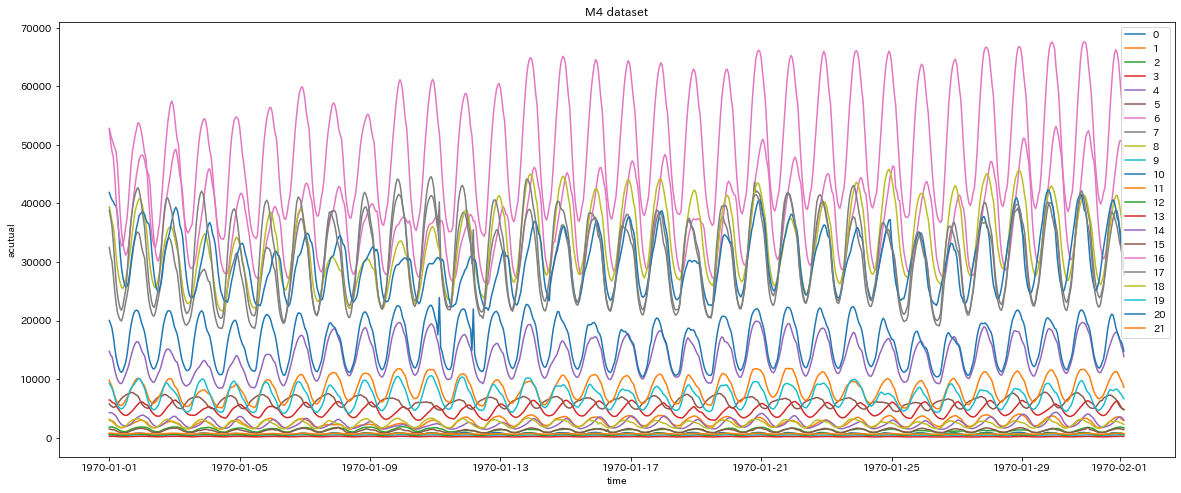

In [ ]:
# グラフ表示
fig = plt.figure(figsize=(20, 8))

plt.title("M4 dataset")
plt.xlabel("time")
plt.ylabel("acutual")

for i in range(len(data["series"].unique())):
    print("i=",i,"data['series'].unique()=",data['series'].unique(),"len(data['series'].unique())=",len(data["series"].unique()))
    each_series_data = data[data["series"]==i]
    print("each_series_data =",each_series_data)
    plt.plot(each_series_data["ds"], each_series_data["value"], label=str(i))
    print("each_series_data[ds]=",each_series_data["ds"],"each_series_data[value]=",each_series_data["value"],"label=",str(i))
plt.legend()
plt.show()

## シード値の固定

In [ ]:
SEED = 42

random.seed(SEED)#
np.random.seed(SEED)#
os.environ["PYTHONHASHSEED"] = str(SEED)

torch.manual_seed(SEED)#乱数を生成するための種を設定します。torch.Generatorオブジェクトを返します。
torch.cuda.manual_seed(SEED)#現在のGPUの乱数生成用のシードを設定します。 CUDAが利用できない場合にこの関数を呼び出しても安全です。その場合、この関数は黙って無視されます。
torch.backends.cudnn.benchmark = False#真であれば、cuDNNは複数の畳み込みアルゴリズムをベンチマークし、最も速いものを選択するようになります。
torch.backends.cudnn.deterministic = True#torch.backends.cudnn.benchmarkが True の時に試行する cuDNNコンボリューションアルゴリズムの最大数を指定するintです。benchmark_limitを0に設定すると、利用可能な全てのアルゴリズムを試すことができます。この設定は、cuDNN v8 APIを通じてディスパッチされた コンボリューションにのみ影響することに注意してください。

pl.seed_everything(SEED)#最初にシードを固定

INFO:lightning_lite.utilities.seed:Global seed set to 42


42

## Pytorch_Forcast with N-Beats

In [ ]:
#on_train_batch_start()をオーバーライドして、何らかの条件が満たされたときに-1 を返すようにすると、現在のエポックの残りを早期に停止してスキップすることができます。
from pytorch_lightning.callbacks import EarlyStopping

#ベースライン(output_size, loss) 直近の既知の目標値を用いて予測を行うベースラインモデル。
#NBeats  共変量なしの時系列予測のためのN-Beatsモデル。
#TimeSeriesDataSet  時系列データセット
from pytorch_forecasting import Baseline, NBeats, TimeSeriesDataSet

#オプションで常にnanとunknownのクラスをクラス0として エンコードできるラベルエンコーダ(変換時)
from pytorch_forecasting.data import NaNLabelEncoder

#共変量なしで多変量データを生成する。各時系列は季節性とトレンドから生成されています
from pytorch_forecasting.data.examples import generate_ar_data

#対称的な平均の割合。y >= 0 を仮定する。メトリクスの初期化 
from pytorch_forecasting.metrics import SMAPE


In [ ]:
# パラメーター
batch_size = 128#学習するデータセットをいくつかのグループのサイズ
EPOCH = 5#学習において、データセットを何週繰り返してパラメータを調整するかを表す数
LR  = 1e-4#学習率 1×10−4     0.0001

In [ ]:
# 使用するGPUの数
if torch.cuda.is_available():#CUDA が現在利用可能かどうかを示すブール値を返します。

    gpu_nums = torch.cuda.device_count()#利用可能な GPU の数を返します。
else:#CUDA が現在利用不可なら
    gpu_nums = 0#利用可能な GPU の数は0を返す

## 学習データ、テストデータの分割

threashold= 1970-01-23 00:00:00
****************************************************************************************************
test size: 0.29411764705882354
****************************************************************************************************


ds  value  series  time_idx  static
528 1970-01-23 00:00:00  809.0       0       528       2
529 1970-01-23 01:00:00  766.0       0       529       2
530 1970-01-23 02:00:00  755.0       0       530       2
531 1970-01-23 03:00:00  703.0       0       531       2
532 1970-01-23 04:00:00  635.0       0       532       2

ds  value  series  time_idx  static
16451 1970-01-31 23:00:00  764.0      21       743       2
16452 1970-02-01 00:00:00  764.0      21       744       2
16453 1970-02-01 01:00:00  763.0      21       745       2
16454 1970-02-01 02:00:00  740.0      21       746       2
16455 1970-02-01 03:00:00  725.0      21       747       2

train=                        ds  value  series  time_idx  static
0     1970-01-01 00:00:00  605.0       0         0       2
1     1970-01-01 01:00:00  586.0       0         1       2
2     1970-01-01 02:00:00  586.0       0         2       2
3     1970-01-01 03:00:00  559.0       0         3       2
4     1970-01-01 04:00:00  511.0       0         4       2
...                   ...    ...     ...       ...     ...
16231 1970-01-22 19:00:00  673.0      21       523       2
16232 1970-01-22 20:00:00  681.0      21       524       2
16233 1970-01-22 21:00:00  693.0      21       525       2
16234 1970-01-22 22:00:00  705.0      21       526       2
16235 1970-01-22 23:00:00  713.0      21       527       2

[11616 rows x 5 columns]
****************************************************************************************************
test=                        ds  value  series  time_idx  static
528   1970-01-23 00:00:00  809.0       0       528       2
529   1970-01-23 01:00:00  766.0  

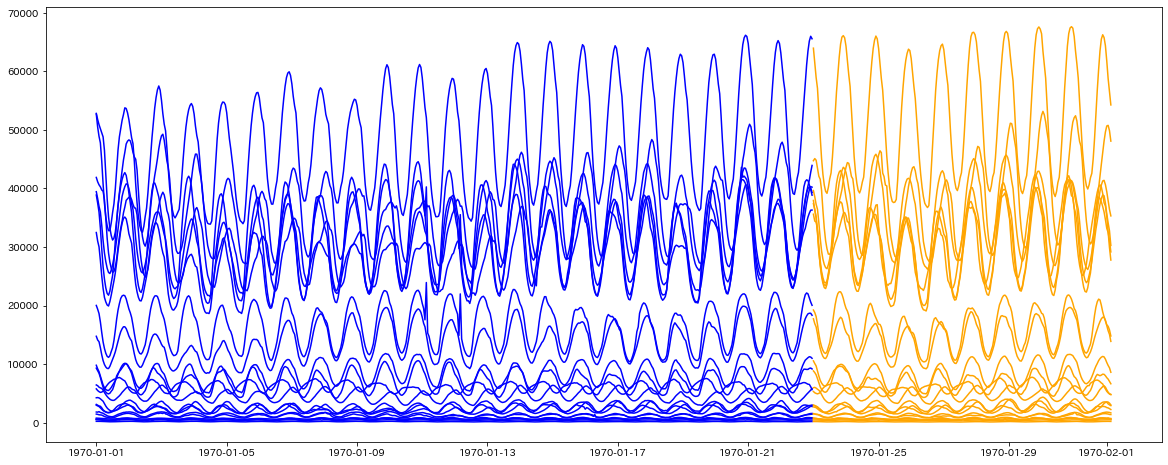

In [ ]:
threashold = datetime.datetime(1970, 1, 23, 0, 0, 0)#閾値の設定
print("threashold=",threashold)
print("*"*100)
print("test size:", len(data[data["ds"]>=threashold]) / len(data["ds"]))
print("*"*100)
display(data[data["ds"]>=threashold].head())
display(data[data["ds"]>=threashold].tail())

train = data[data["ds"]<threashold]
print("train=",train)
print("*"*100)
test = data[data["ds"]>=threashold]
print("test=",test)
print("*"*100)
# テスト
assert len(data) == (len(train) + len(test))
print()
# グラフ表示
fig = plt.figure(figsize=(20, 8))
series_list = train["series"].unique()
print("series_list=",series_list)
print("*"*100)
for i in range(len(series_list)):
    print("i=",i,"len(series_list)= ",len(series_list))
    print("*"*100)
    plt.plot(
        train[train["series"]==series_list[i]]["ds"], 
        train[train["series"]==series_list[i]]["value"], 
        color="blue"
        )

    plt.plot(
        test[test["series"]==series_list[i]]["ds"], 
        test[test["series"]==series_list[i]]["value"], 
        color="orange"
        )

In [ ]:
train

ds  value  series  time_idx  static
0     1970-01-01 00:00:00  605.0       0         0       2
1     1970-01-01 01:00:00  586.0       0         1       2
2     1970-01-01 02:00:00  586.0       0         2       2
3     1970-01-01 03:00:00  559.0       0         3       2
4     1970-01-01 04:00:00  511.0       0         4       2
...                   ...    ...     ...       ...     ...
16231 1970-01-22 19:00:00  673.0      21       523       2
16232 1970-01-22 20:00:00  681.0      21       524       2
16233 1970-01-22 21:00:00  693.0      21       525       2
16234 1970-01-22 22:00:00  705.0      21       526       2
16235 1970-01-22 23:00:00  713.0      21       527       2

[11616 rows x 5 columns]

## 学習

# TimeSeriesSplit

時系列クロスバリデーター

一定時間間隔で観測される時系列データサンプルを、トレーニングセットとテストセットに分割するためのトレーニング/テストインデックスを提供する。 各分割において、テストインデックスは以前より高くなければならないため、クロスバリデータのシャッフリングは不適切である。

このクロスバリデーションオブジェクトはKFoldを変形したもので、k回目の分割で、最初のkフォールドをトレーニングセット、(k+1)回目をテストセットとして返します。

標準的な交差検証法とは異なり、連続した学習セットは、その前のセットのスーパーセットであることに注意してください。

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs


fold= 0 train_index= [   0    1    2 ... 1713 1714 1715] valid_index= [1716 1717 1718 ... 3693 3694 3695]


INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


baseline absolute error :0.04478739947080612


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.tuner.lr_finder:LR finder stopped early after 40 steps due to diverging loss.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_dd11723a-4d72-4278-8a96-885dc72d5564.ckpt


KeyError: ignored

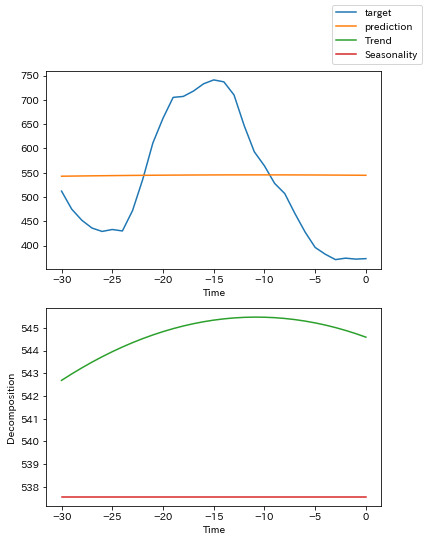

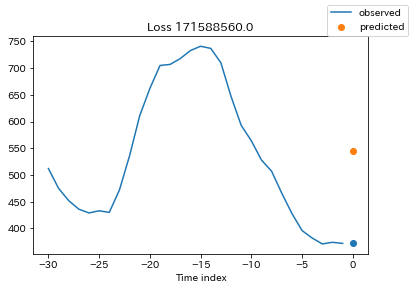

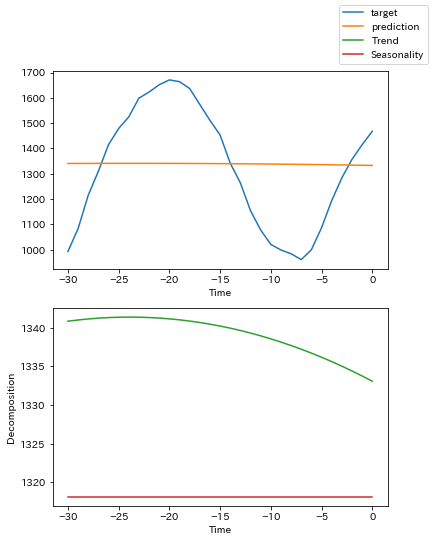

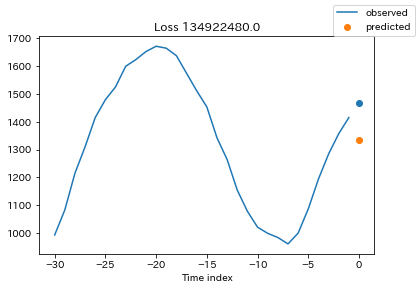

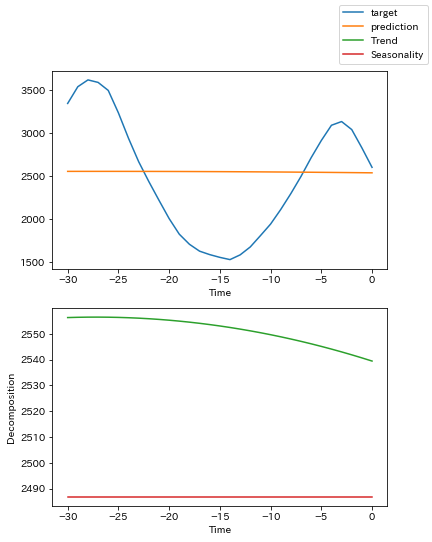

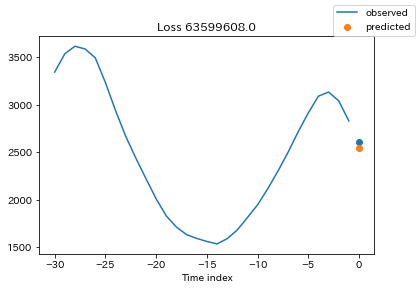

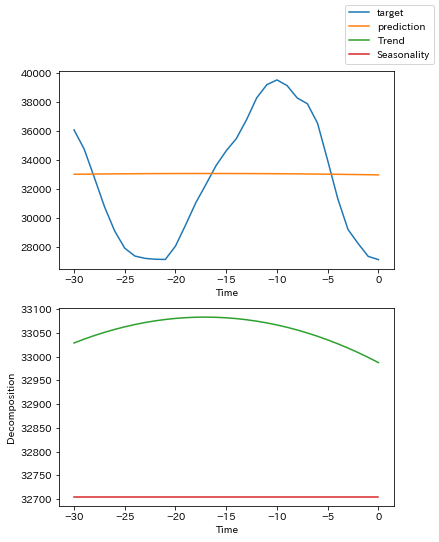

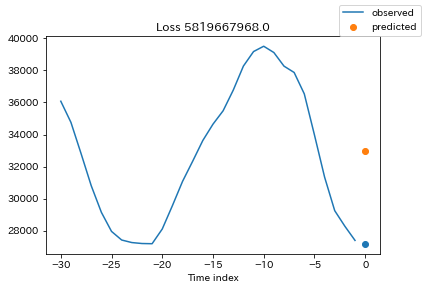

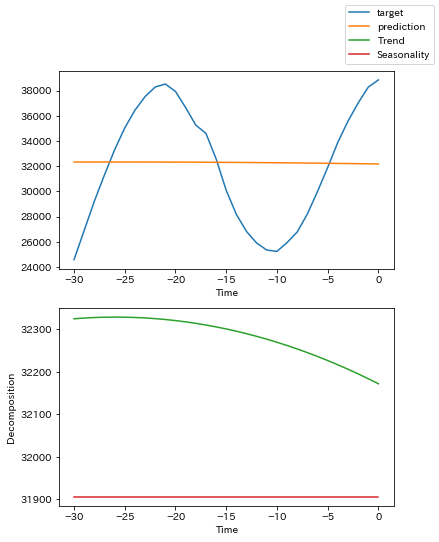

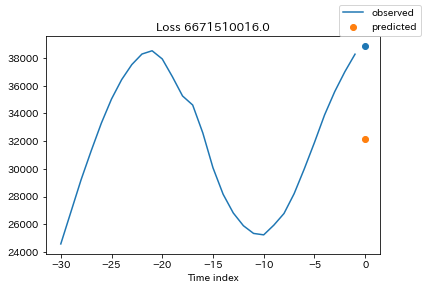

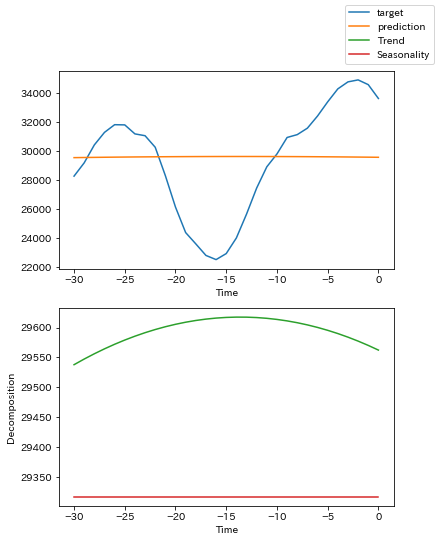

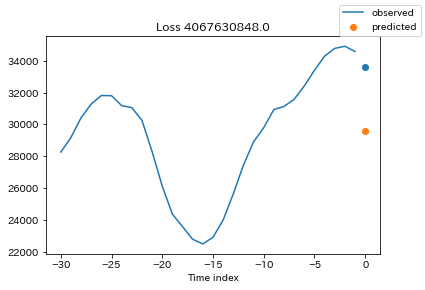

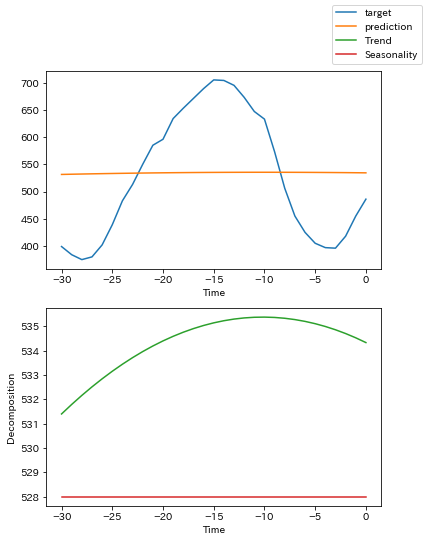

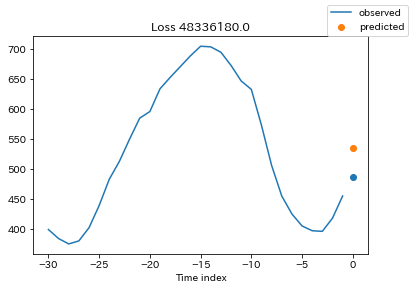

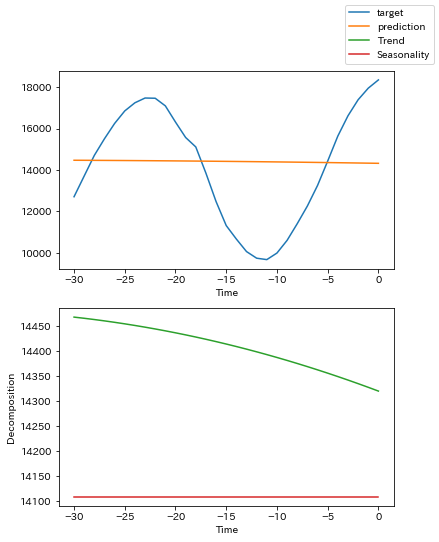

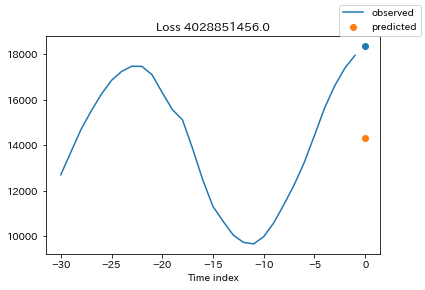

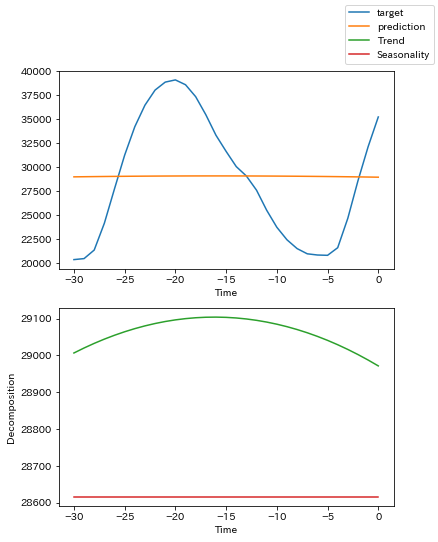

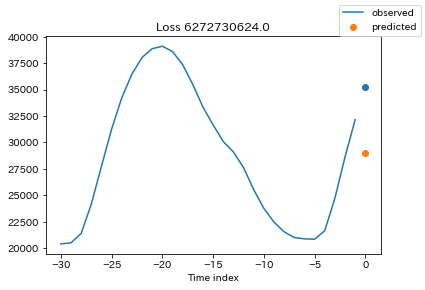

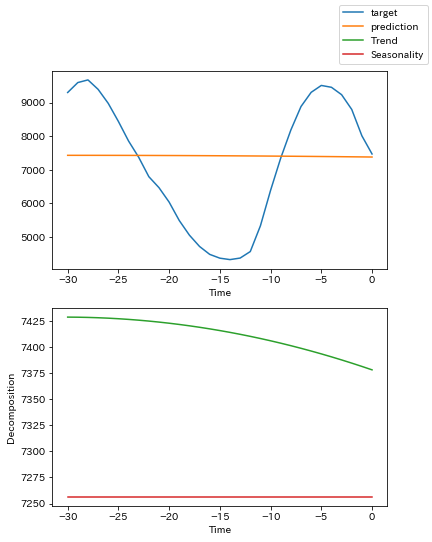

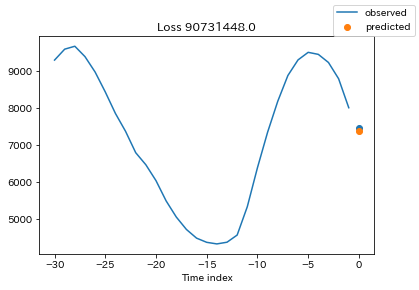

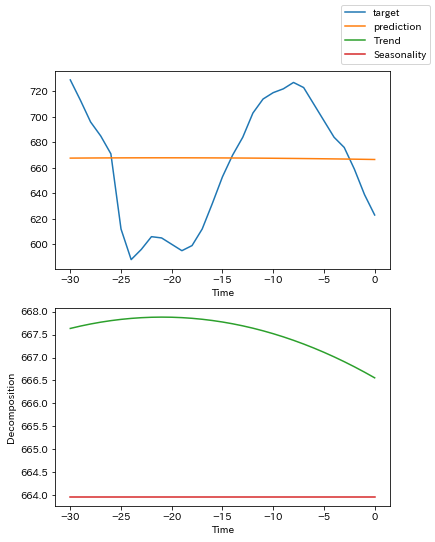

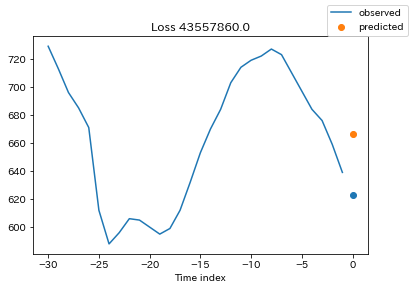

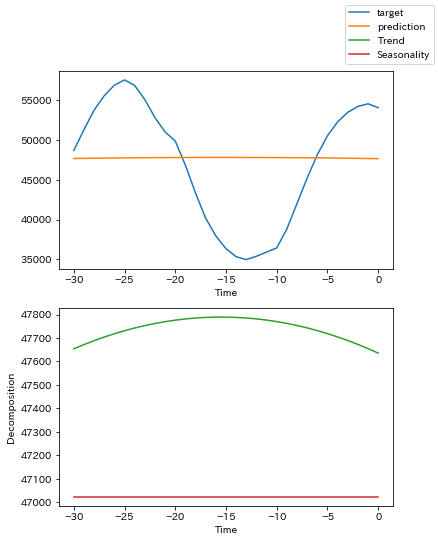

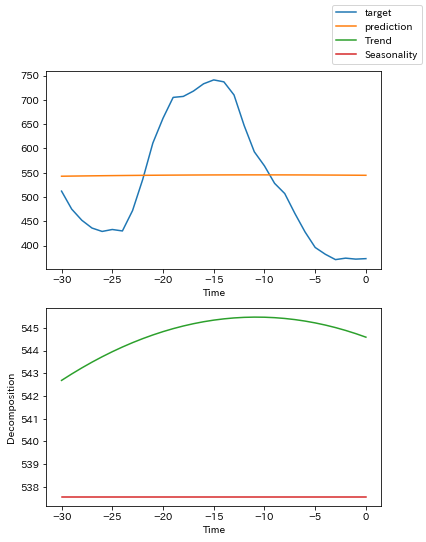

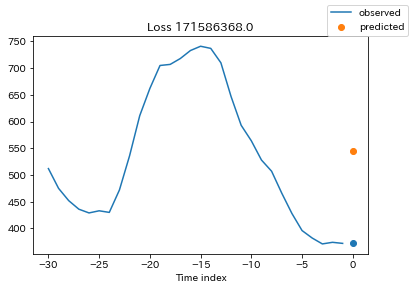

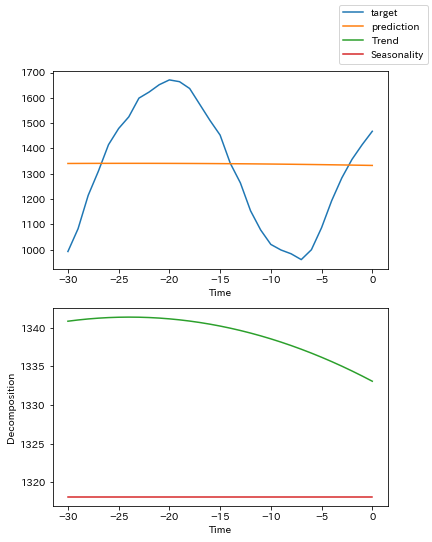

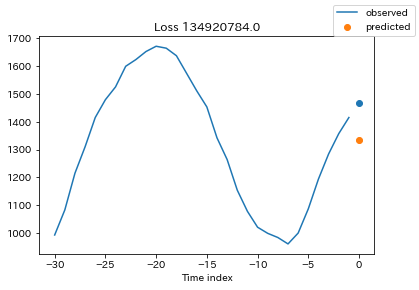

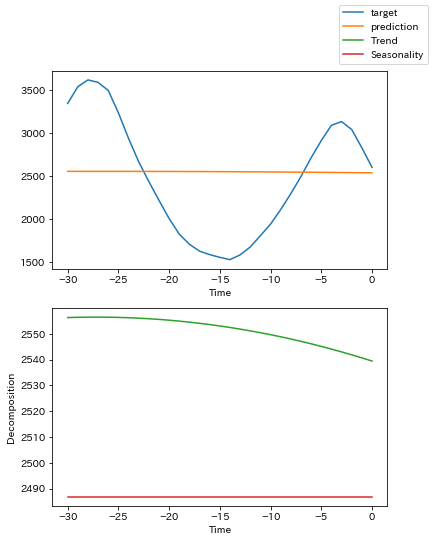

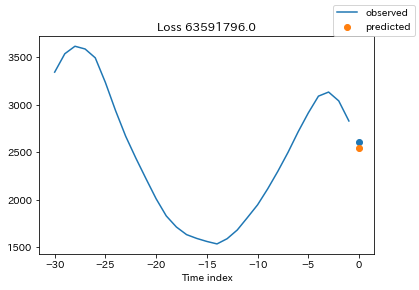

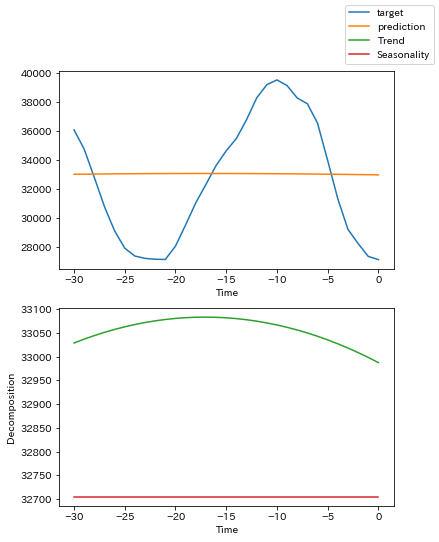

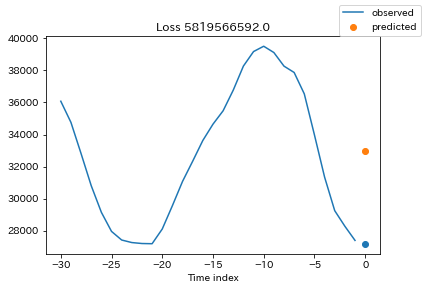

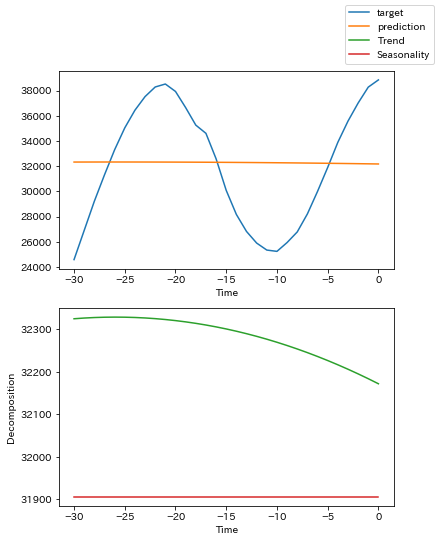

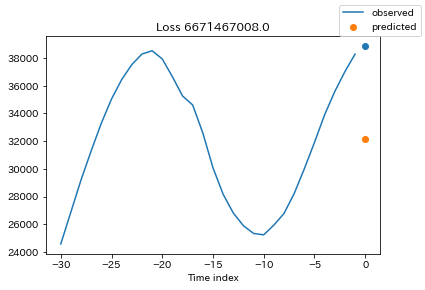

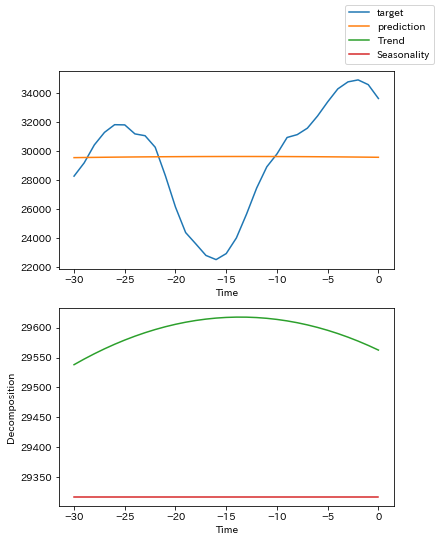

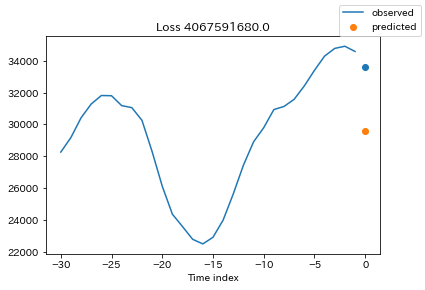

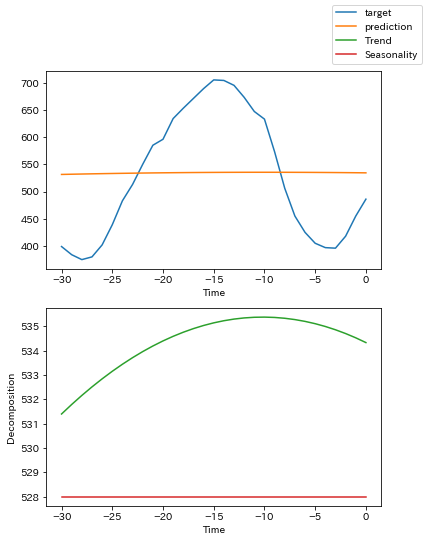

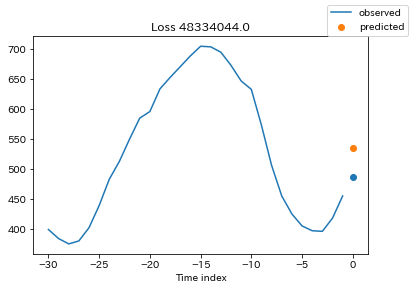

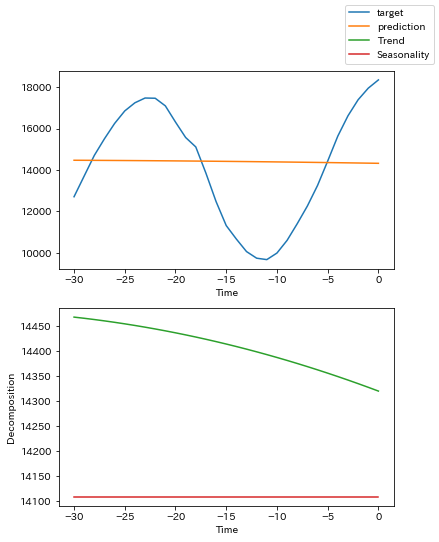

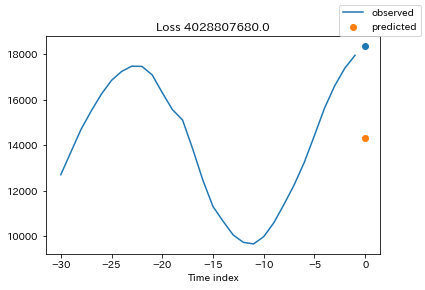

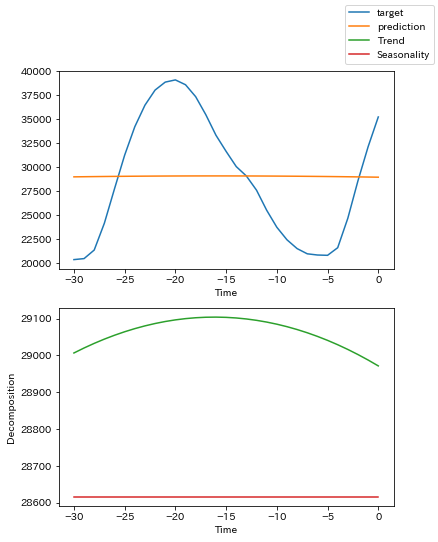

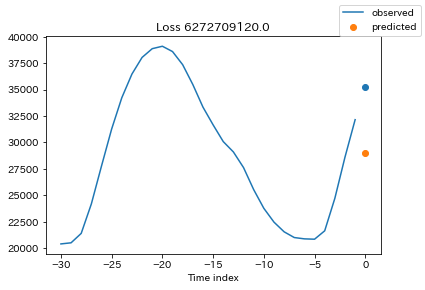

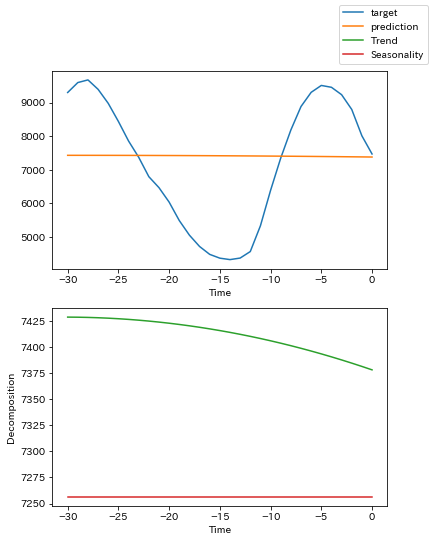

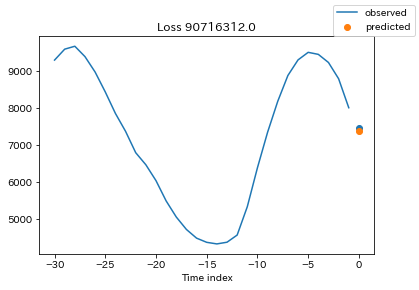

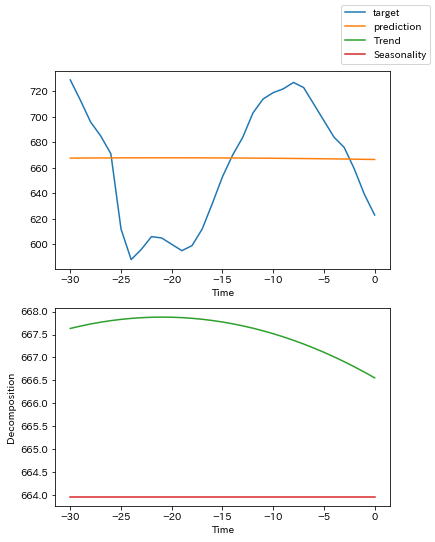

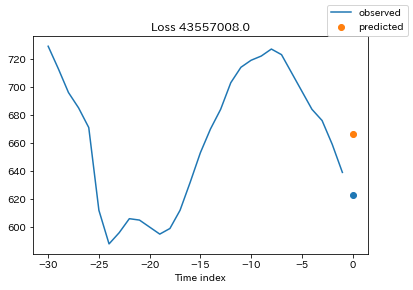

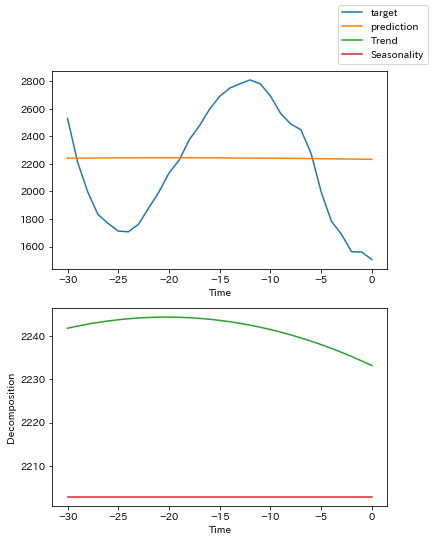

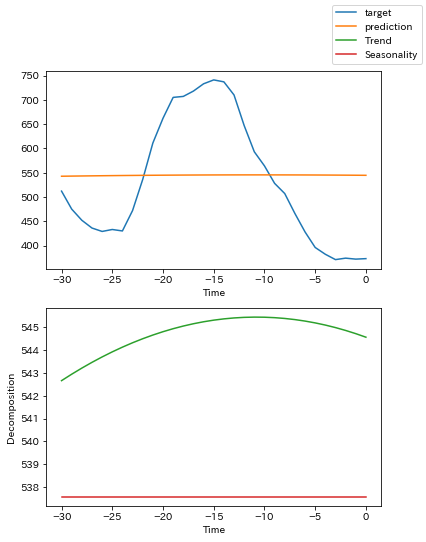

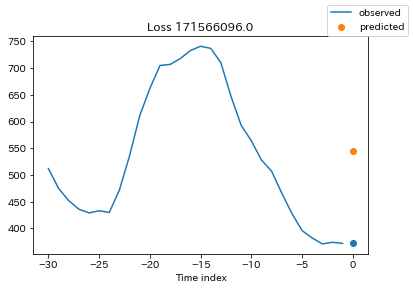

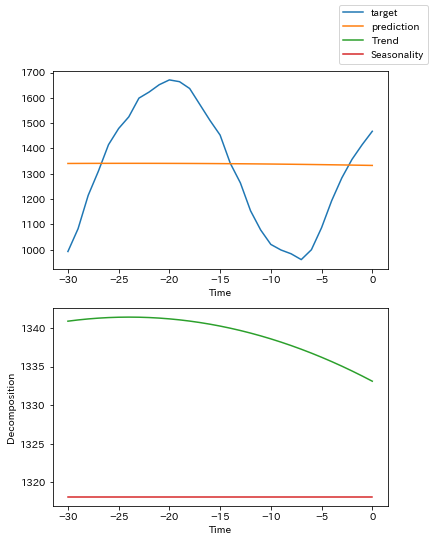

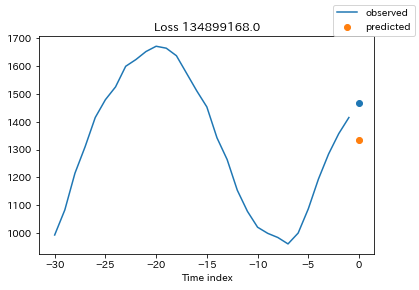

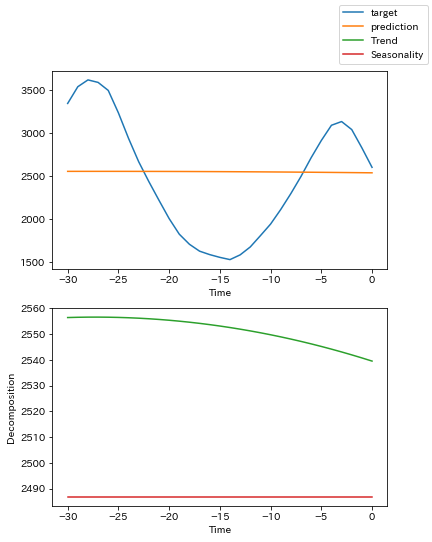

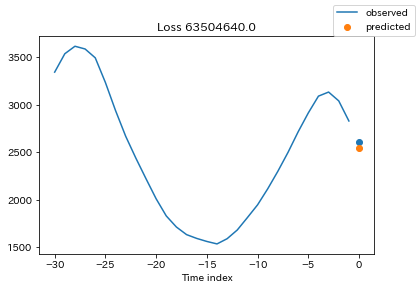

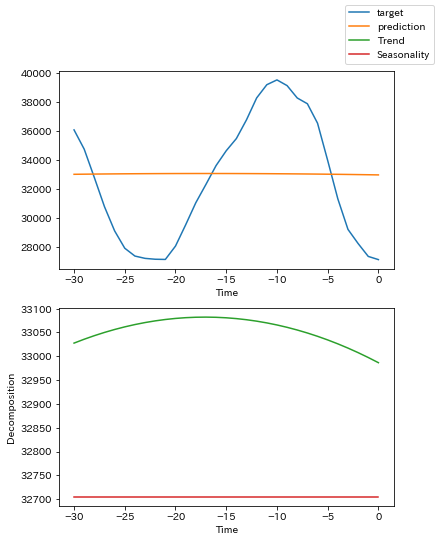

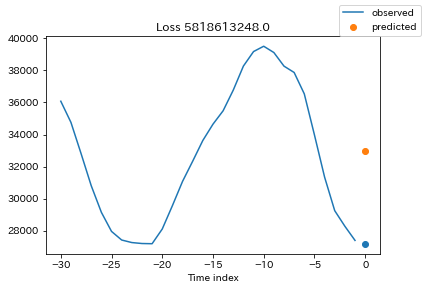

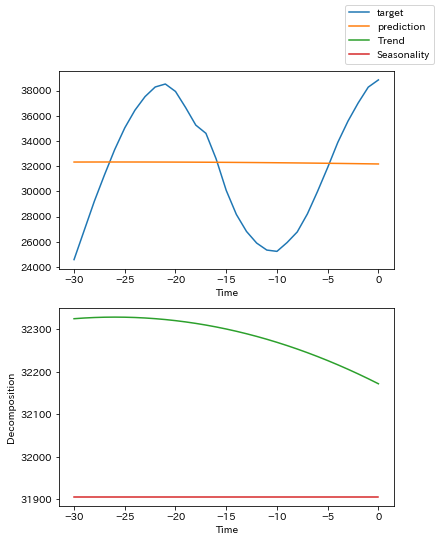

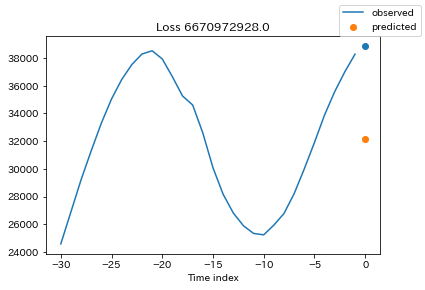

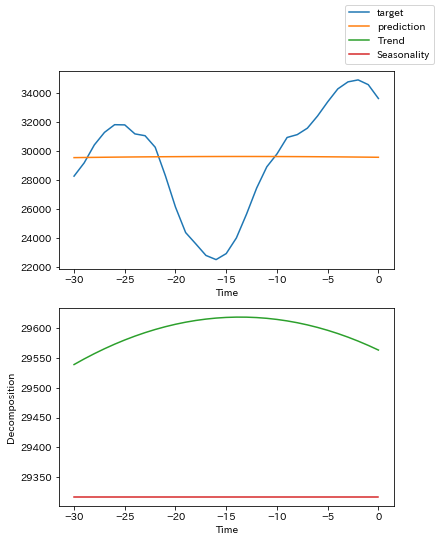

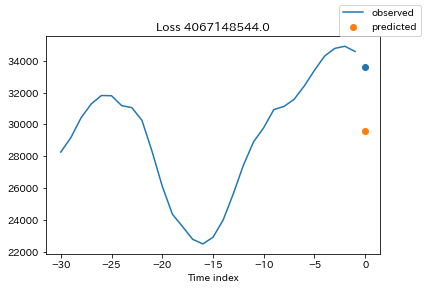

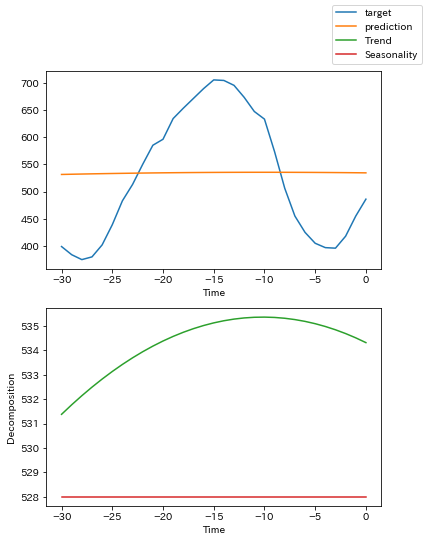

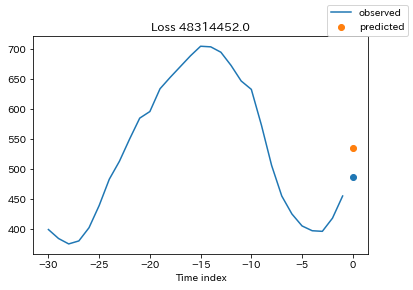

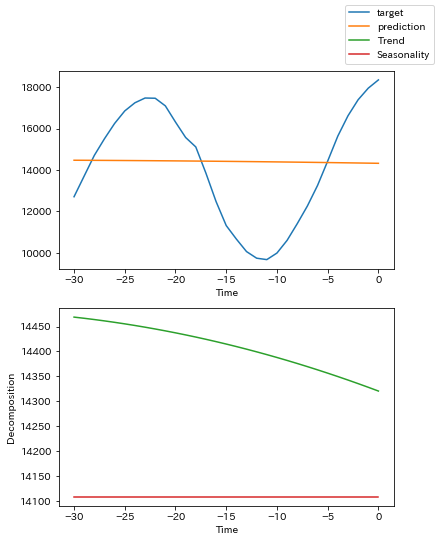

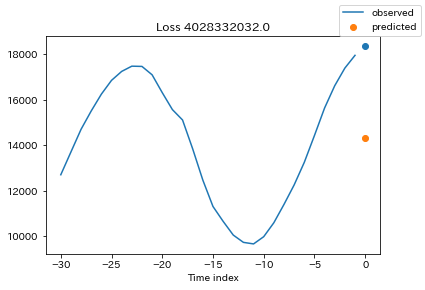

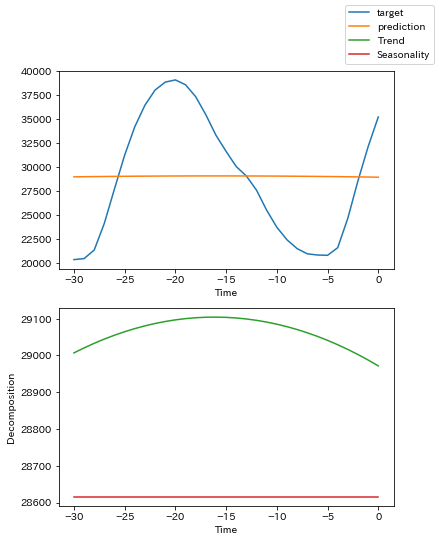

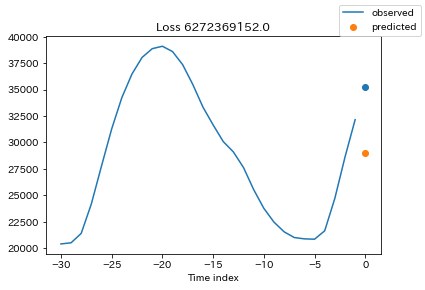

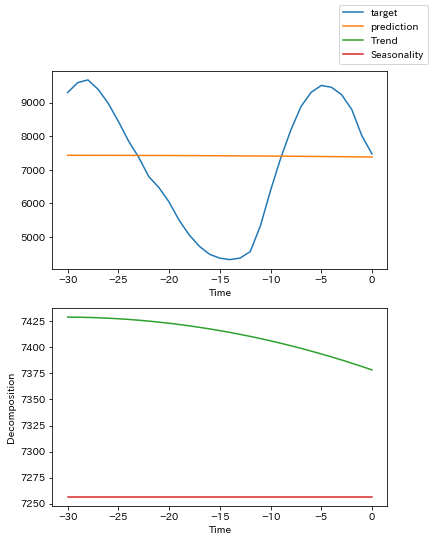

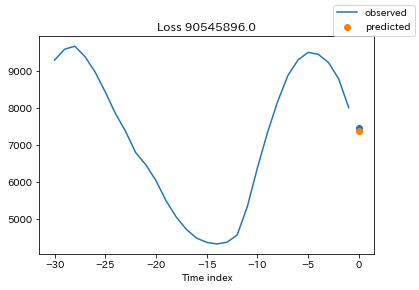

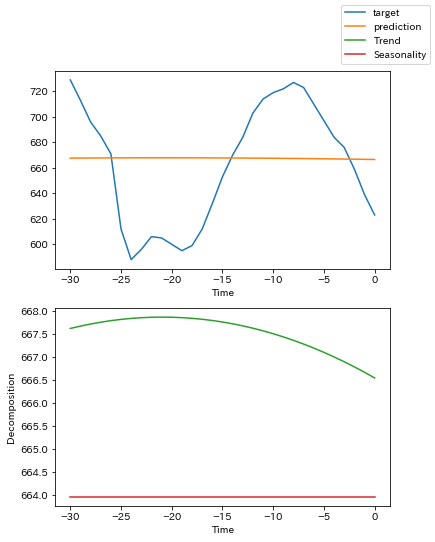

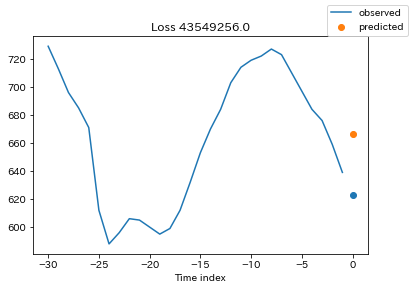

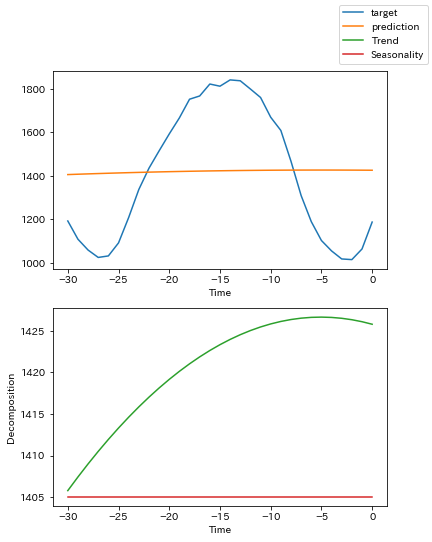

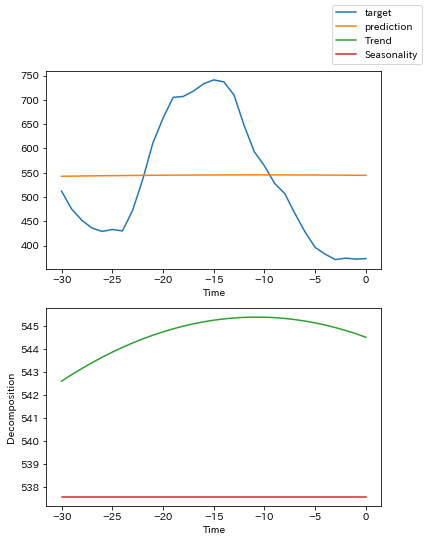

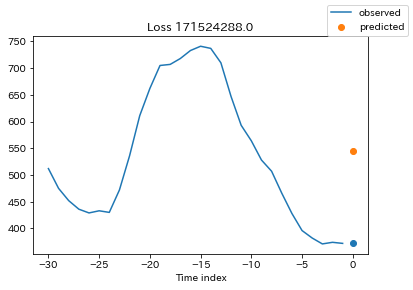

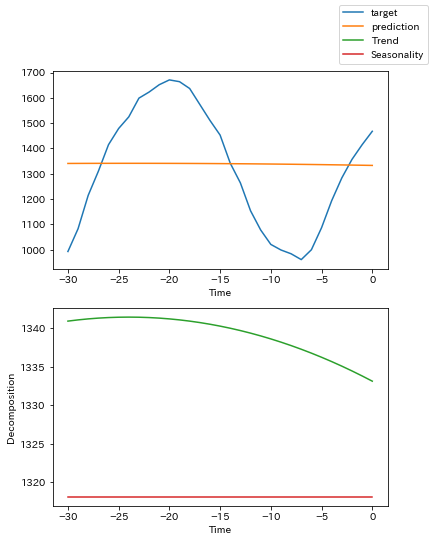

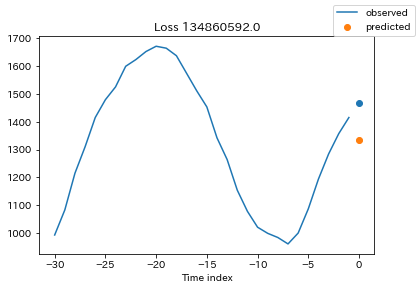

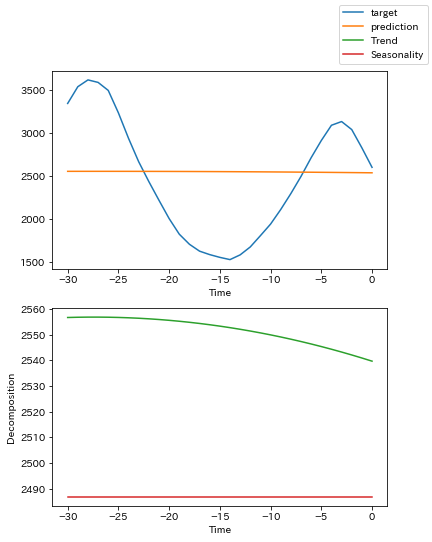

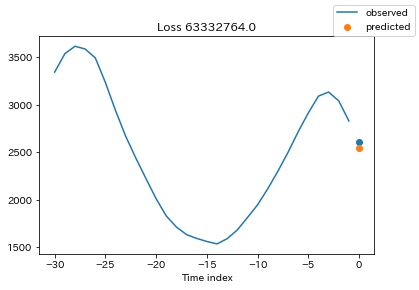

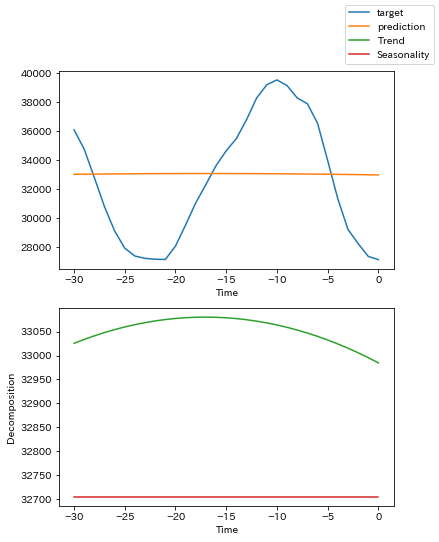

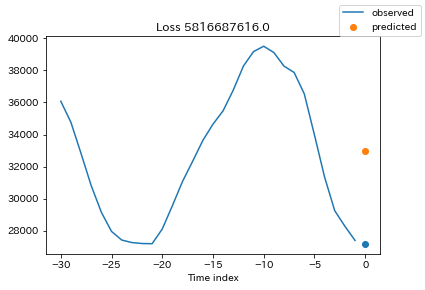

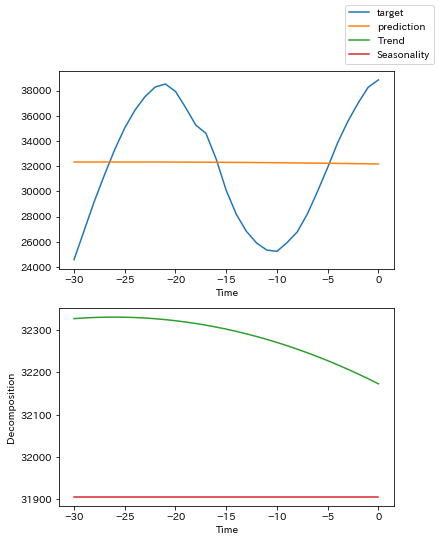

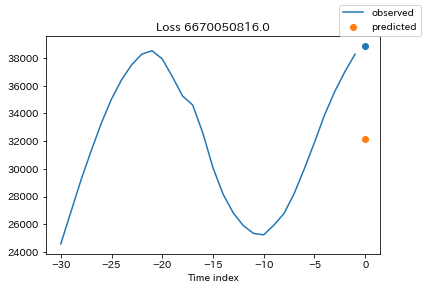

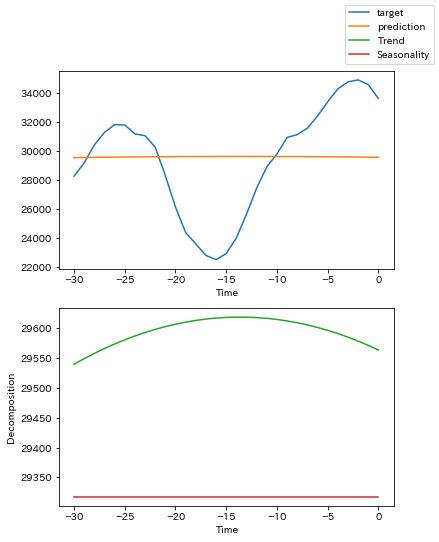

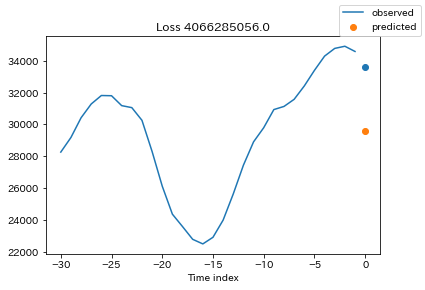

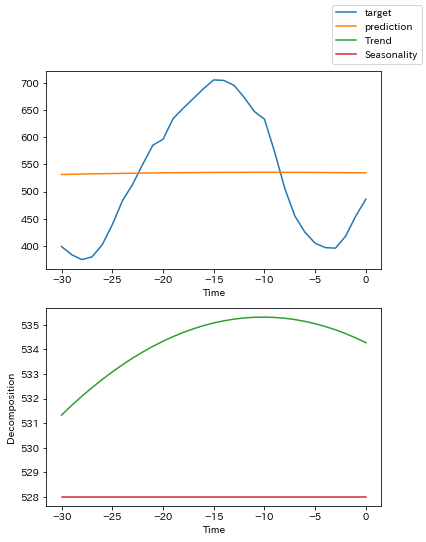

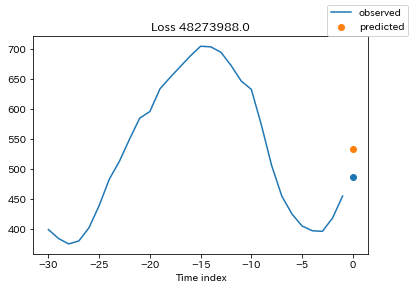

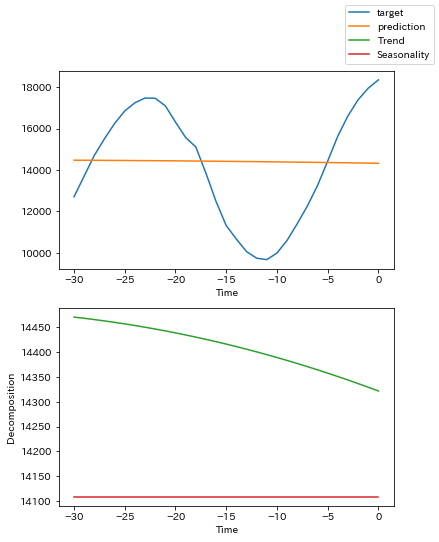

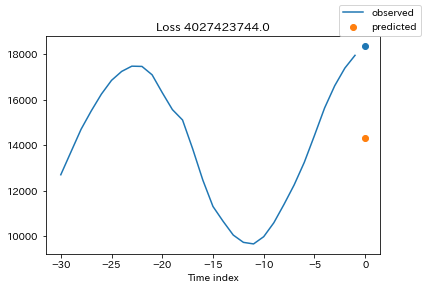

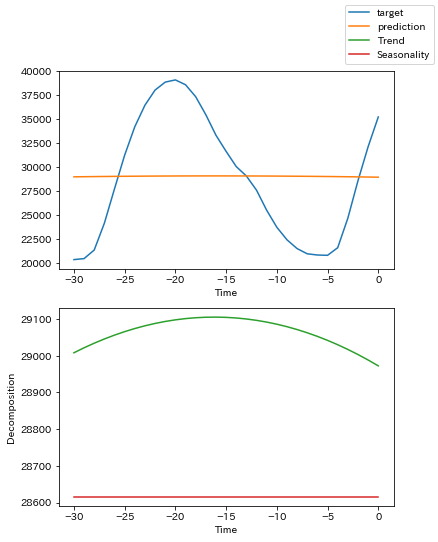

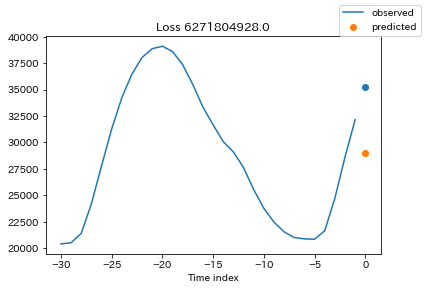

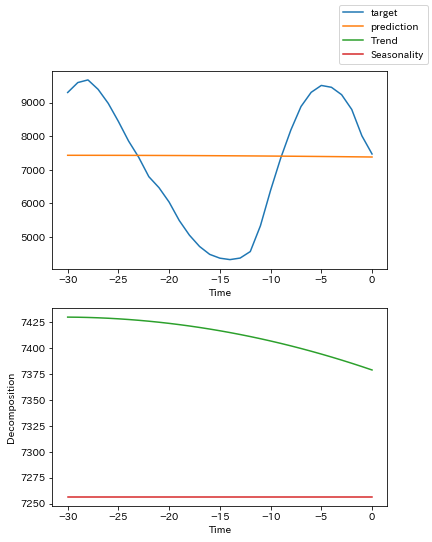

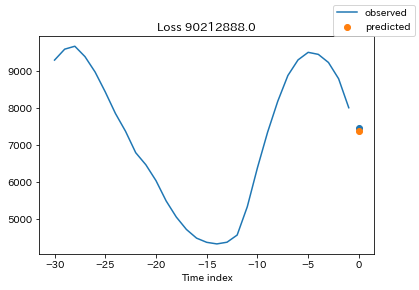

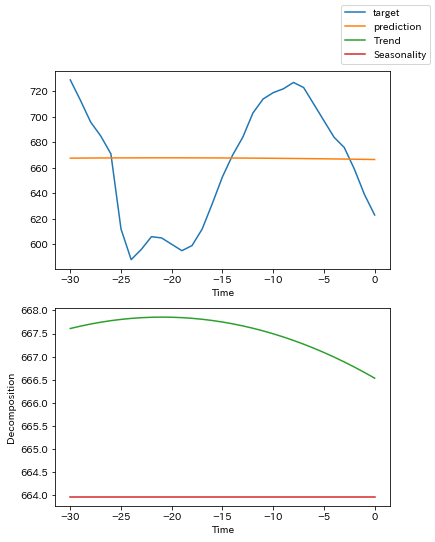

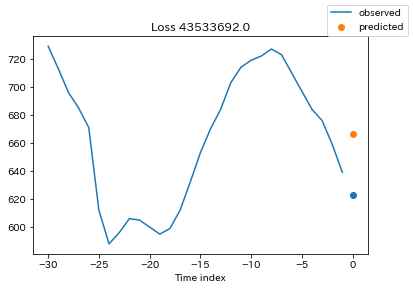

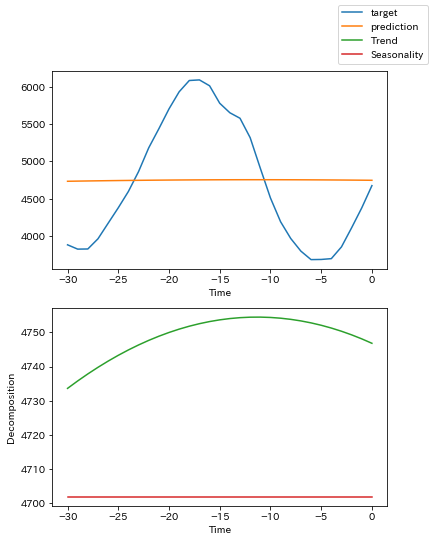

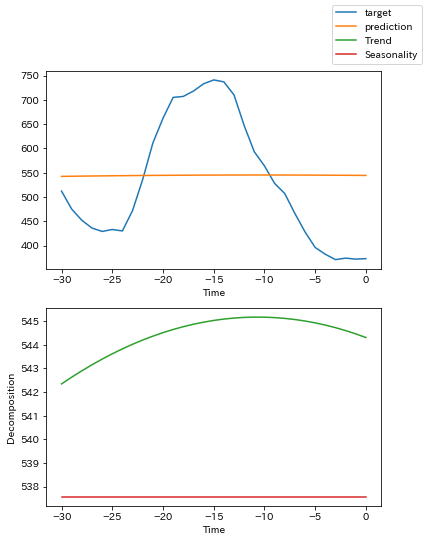

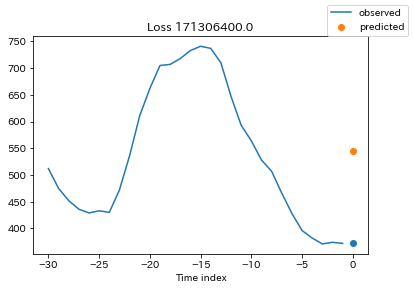

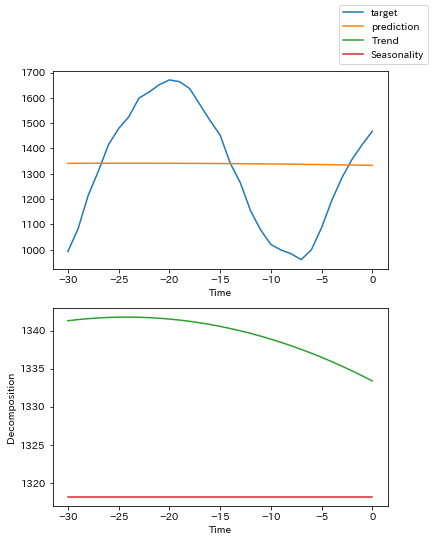

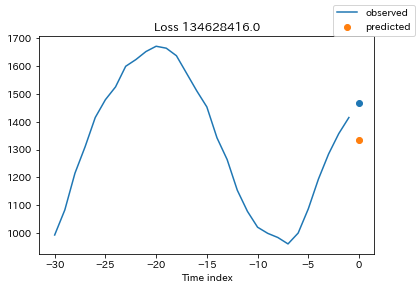

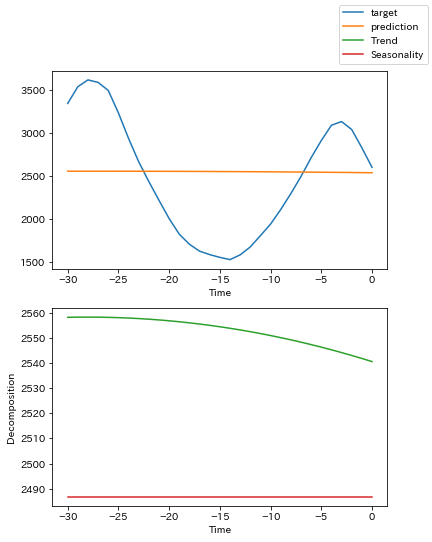

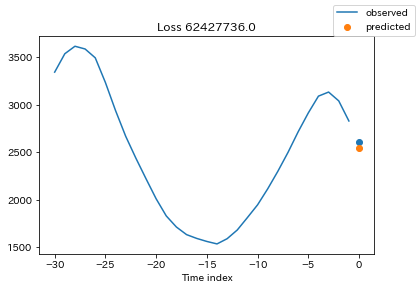

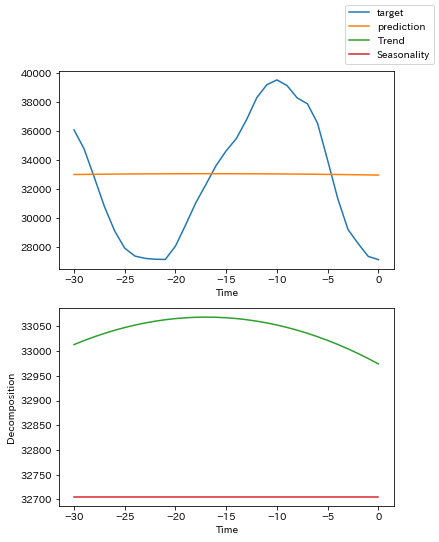

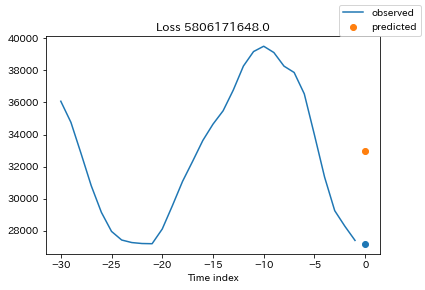

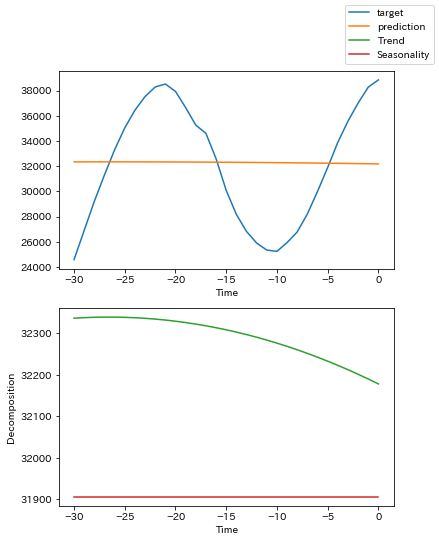

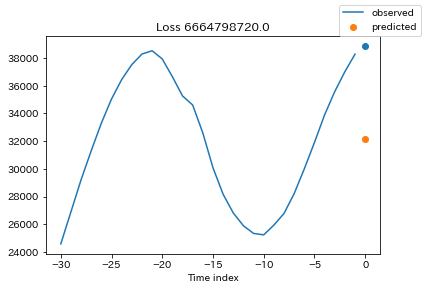

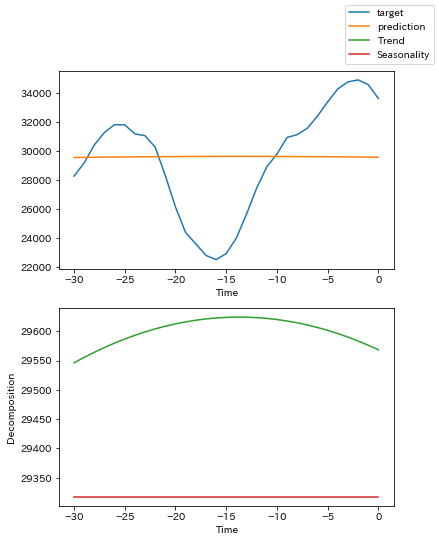

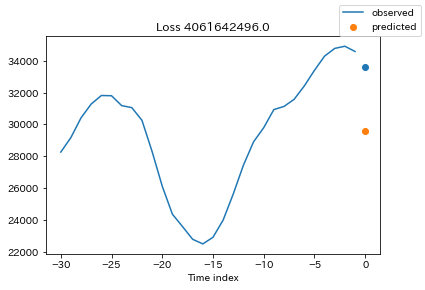

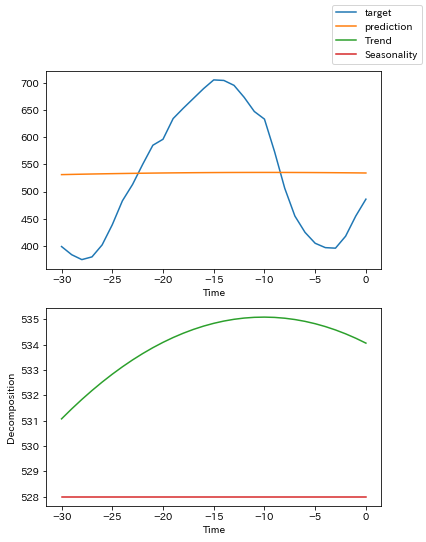

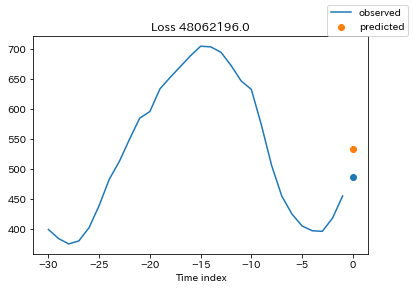

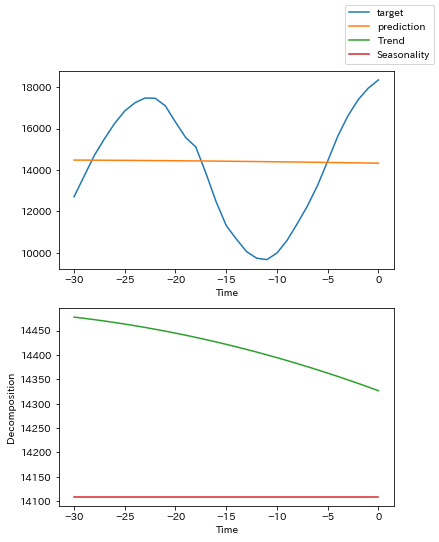

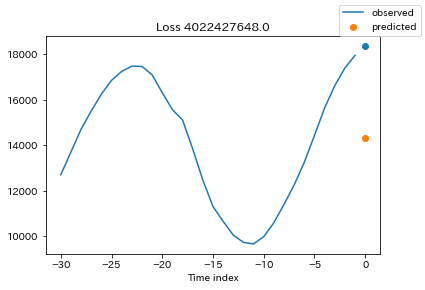

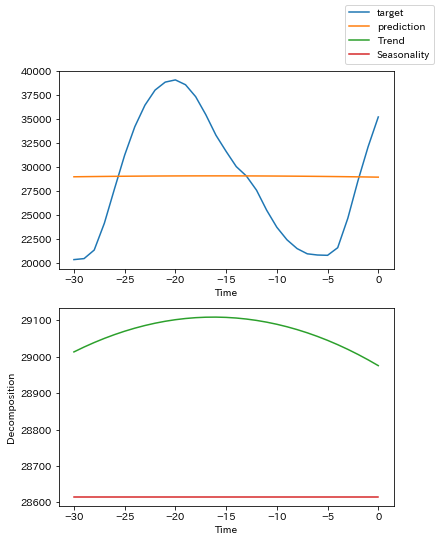

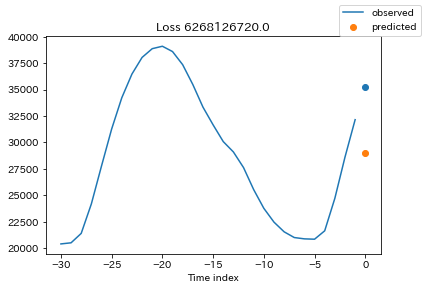

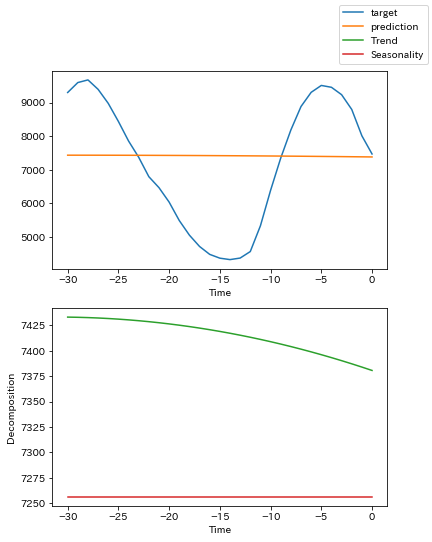

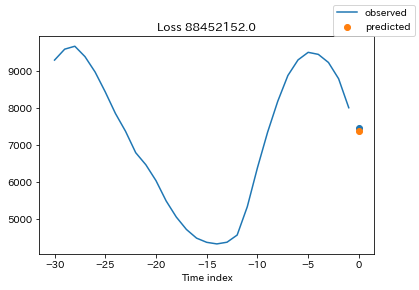

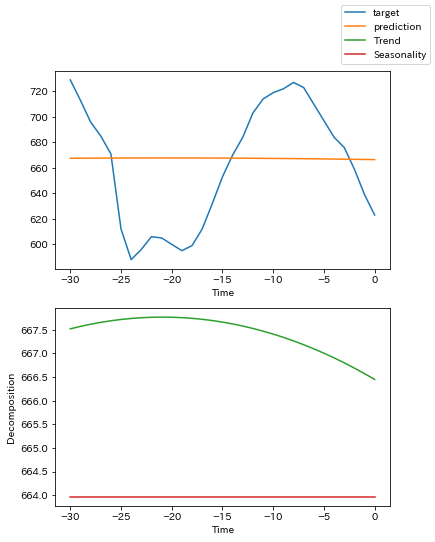

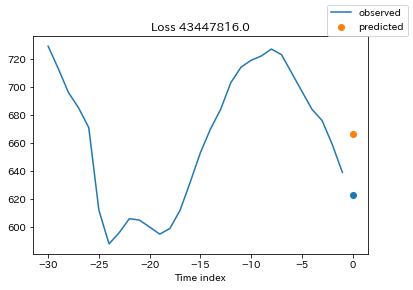

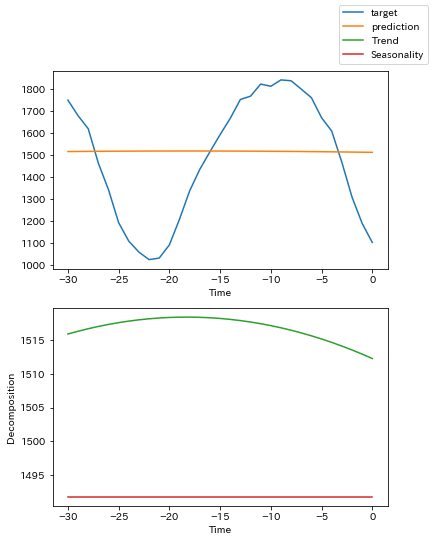

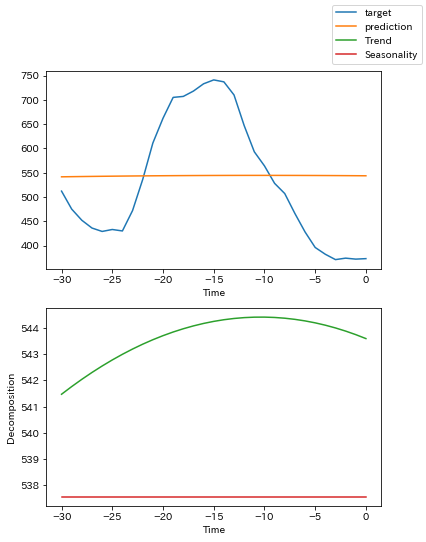

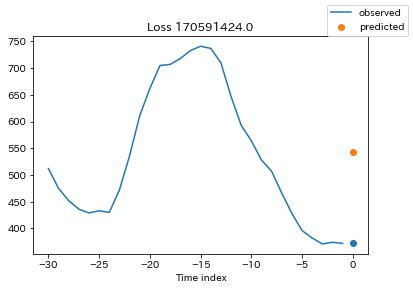

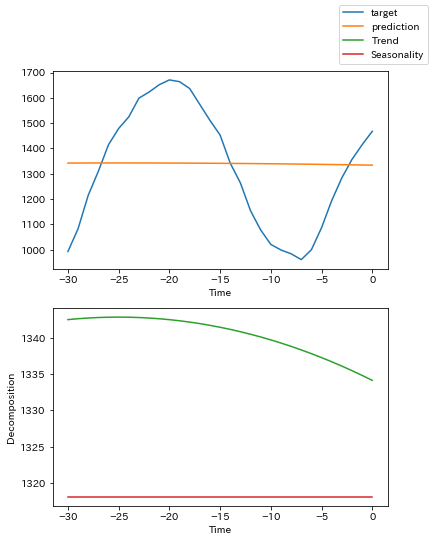

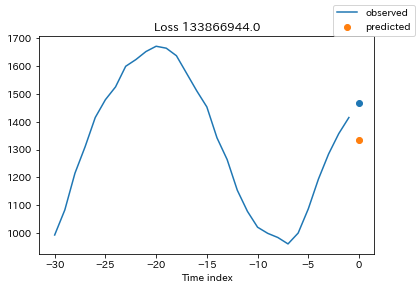

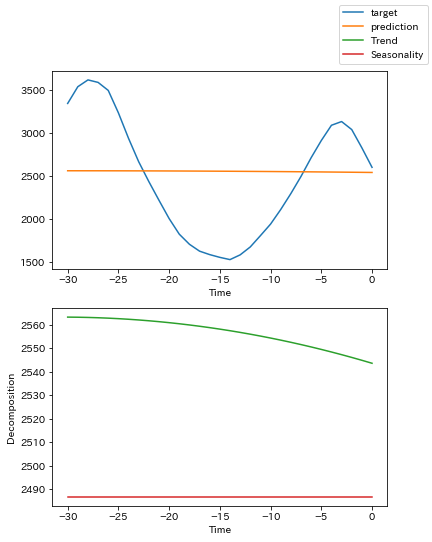

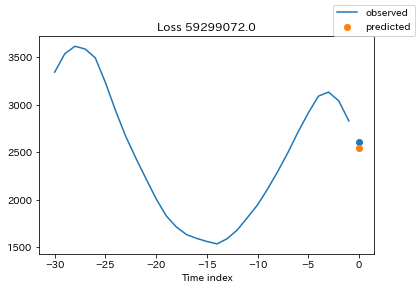

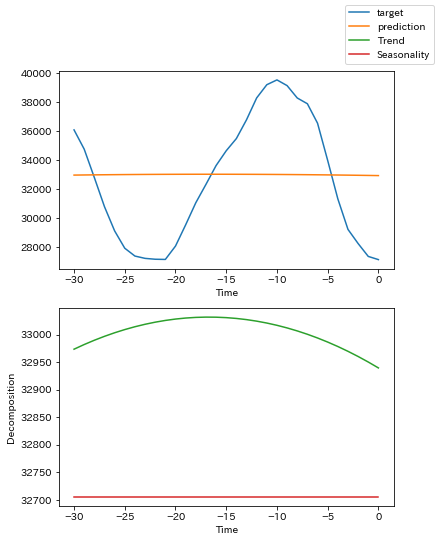

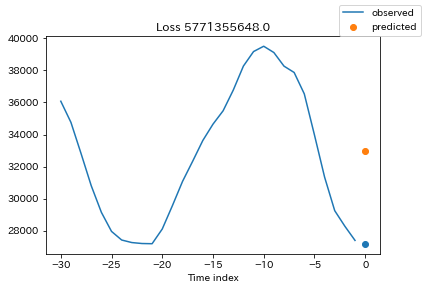

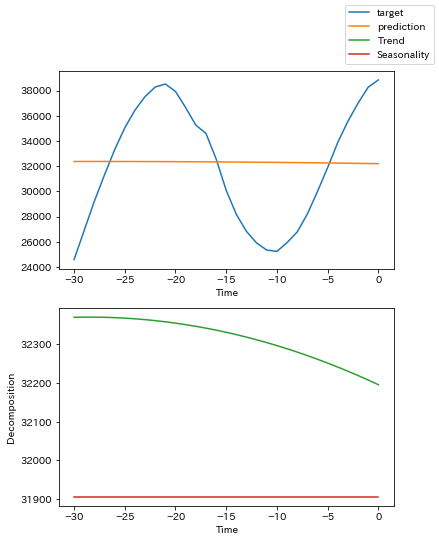

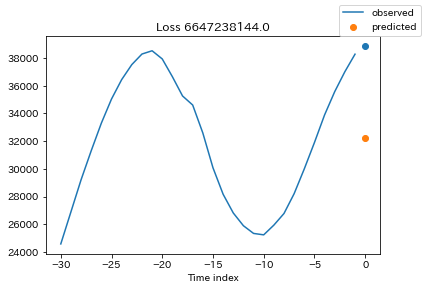

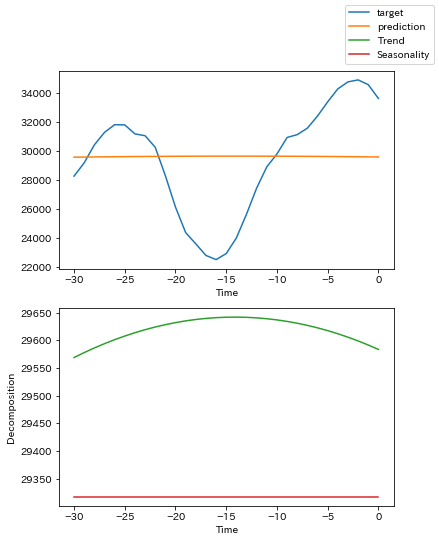

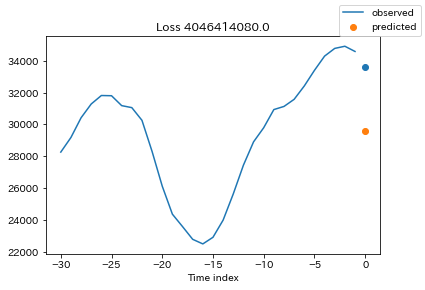

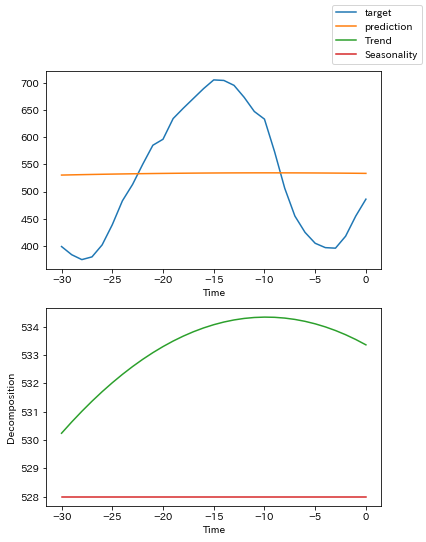

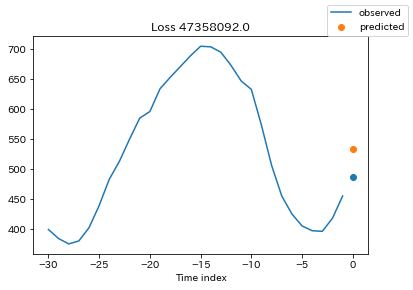

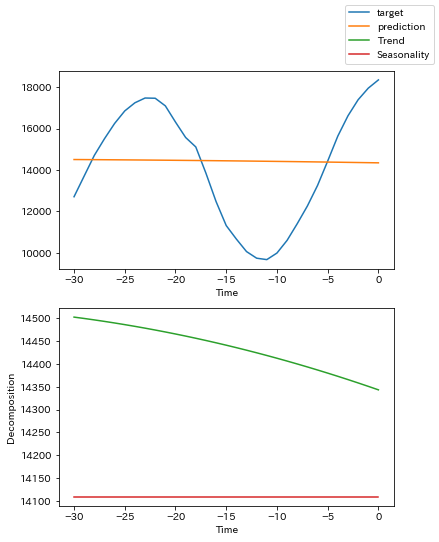

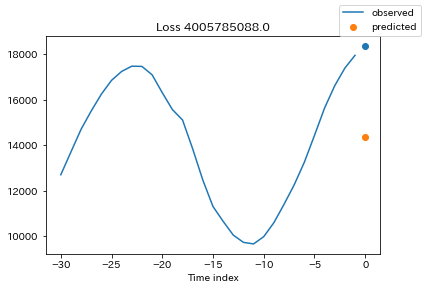

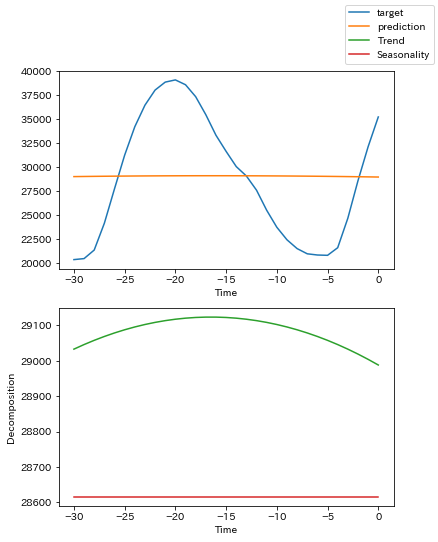

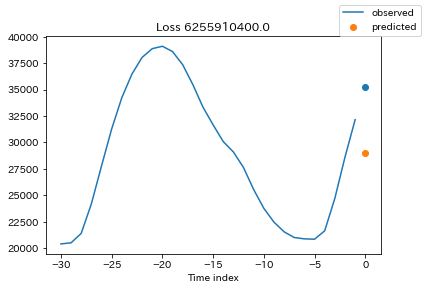

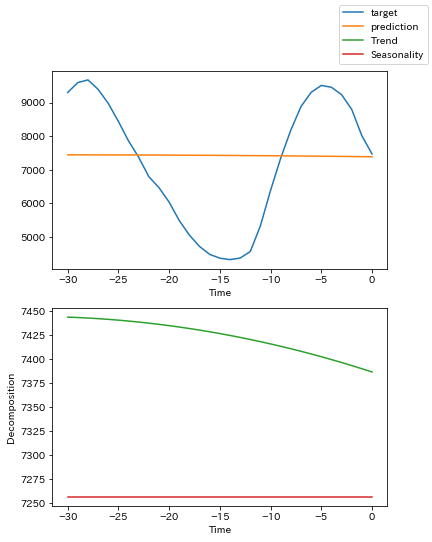

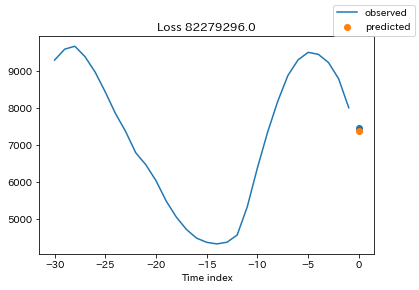

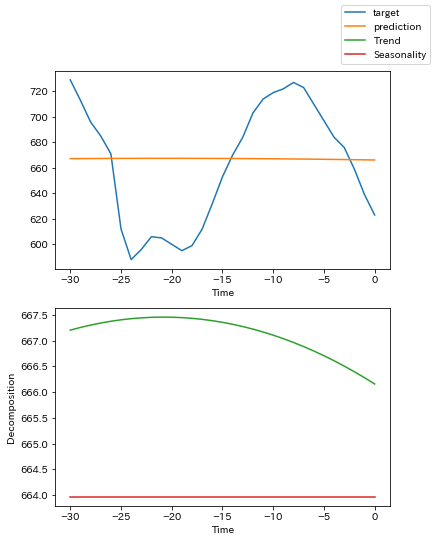

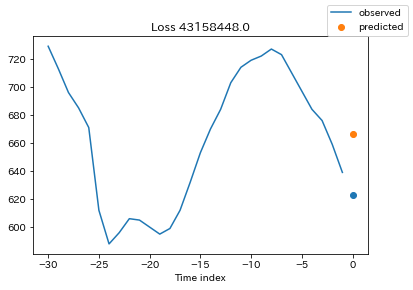

In [ ]:
### 交差検証
FOLD = 5
cross_rmse_nbeats = []

train_sort = train.sort_values(["ds", "series"])

tscv = TimeSeriesSplit(n_splits=FOLD, test_size=22*90)

for fold, (train_index, valid_index) in enumerate(tscv.split(train)):
    print("fold=",fold,"train_index=",train_index,"valid_index=",valid_index)

    # 学習用データセットの作成 https://pytorch-forecasting.readthedocs.io/en/latest/api/pytorch_forecasting.data.timeseries.TimeSeriesDataSet.html#timeseriesdataset
    training = TimeSeriesDataSet(
        train_sort.iloc[train_index],#data(pd.DataFrame) - シーケンスデータのデータフレーム - 各行はtime_idxとgroup_idsで識別できる．
        time_idx="time_idx",#time_idx(str) - 時刻インデックスを示す 整数カラム。この列はサンプルの順序を決定するために使用される。 欠測がない場合、時間インデックスは後続のサンプルごとに+1ずつ増加する。 各シリーズの最初の time_idx は必ずしも0である必要はなく、任意の値が許容される。
        target="value",#ターゲットを示す列、またはターゲットを示す列のリスト -カテゴリまたは連続値。
        categorical_encoders={"series": NaNLabelEncoder().fit(data.series)},
        group_ids=["series"],#scikit learn のラベル変換器の辞書。 将来的に観測されないカテゴリがある場合 / コールドスタート問題がある場合、add_nan=True でNaNLabelEncoderを使うことができる。デフォルトは事実上sklearnのLabelEncoder()である。プリフィッテッドエンコーダは再度フィッテングされることはない。
        # only unknown variable is "value" - and N-Beats can also not take any additional variables
        time_varying_unknown_reals=["value"],#時間の経過とともに変化し、将来的にはわからない連続変数のリスト。 ここにターゲットを入れておくとよい。
    )

    # 検証用データセットの作成
    validation = TimeSeriesDataSet(
        train_sort.iloc[valid_index],#data(pd.DataFrame) - シーケンスデータのデータフレーム - 各行はtime_idxとgroup_idsで識別できる．
        time_idx="time_idx",#時刻インデックスを示す 整数列．この列は，サンプルの順序を決定するために使用される． 見逃し観測がない場合，時間インデックスは後続のサンプルごとに+1ずつ増加する． 各シリーズの最初の time_idx は必ずしも0である必要はなく，任意の値が許容される．
        target="value",#ターゲットを示す列、またはターゲットを示す列のリスト -カテゴリ別または連続的。
        categorical_encoders={"series": NaNLabelEncoder().fit(data.series)},#cikit learn のラベル変換器の辞書。 将来的に観測できないカテゴリがある場合 / コールドスタート問題がある場合、add_nan=True でNaNLabelEncoderを使うことができる。デフォルトは事実上sklearnのLabelEncoder()である。プリフィッテッドエンコーダは再度フィッテングされることはない。
        group_ids=["series"],#- 時系列を識別するカラム名のリスト。つまり、group_idsは time_idxとともにサンプルを特定する。時系列が1つしかない場合は、一定となる列の名前を設定する。
        time_varying_unknown_reals=["value"],# 時間変化する既知の範疇のもの  時間の経過とともに変化し、将来的にはわからない連続変数のリスト。 ここにターゲットを入れておくとよい。
    )

    # データローダーの作成 to_dataloader([train, batch_size, batch_sampler])データセットからdataloaderを取得する。
    train_dataloader = training.to_dataloader(train=True, #訓練または予測にdataloaderを使用するかどうか。デフォルトはTrue。
                                              batch_size=batch_size, #学習モデル用のバッチサイズ．デフォルトは 64
                                              num_workers=2)
    val_dataloader = validation.to_dataloader(train=False, #訓練または予測にdataloaderを使用するかどうか。デフォルトはTrue。
                                              batch_size=batch_size, #学習モデル用のバッチサイズ．デフォルトは 64
                                              num_workers=2)

    # モデル作成 pl.Trainer フラッグでトレーニングのあらゆる面をカスタマイズ。
    #https://pytorch-lightning.readthedocs.io/en/latest/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=Trainer
    trainer = pl.Trainer(
        gpus=gpu_nums, #ノードごとに適用するGPUの数(int)またはどのGPUで学習させるか(listまたはstr) デフォルト:なし
        #バージョンv1.7から非推奨: gpusはv1.7で非推奨となり、v2.0で削除されます。代わりにaccelerator='gpu'とdevices=xを使ってください。
        gradient_clip_val=0.01,#-グラデーションをクリップする値。
        deterministic=True#True の場合、PyTorch の操作が決定論的アルゴリズムを使わなければならないかを設定します。
        #warn"に設定すると、可能な限り決定論的アルゴリズムを使い、決定論モードをサポートしない操作に対して警告を投げます (requires PyTorch 1.11+).設定されていない場合、デフォルトはFalse です。 デフォルトは None です。なし。
        )
    #TimeSeriesDataSet` からネットワークを作成するための便利な関数です。
    #https://pytorch-forecasting.readthedocs.io/en/latest/api/pytorch_forecasting.models.nbeats.NBeats.html#pytorch_forecasting.models.nbeats.NBeats
    net = NBeats.from_dataset(
        training, #学習用データセット
        learning_rate=LR,# 学習率　 1e-4
        weight_decay=1e-2,# 重みの減衰。デフォルトは 0.0 です
        widths=[32, 512], #ブロック内のReLu活性化された完全連結層の幅。
        backcast_loss_ratio=0.1#損失を計算する際に、予測との比較でバックキャストの重み。
        #重み付けが1.0であれば、予測損失とバックキャスト損失は同じ重み付けになる（バックキャストと予測される長さ）。
        #デフォルトは0.0、つまり重みなし。
    )

    #指標をモニタリングし、改善が見られなくなったらトレーニングを中止する
    early_stop_callback = EarlyStopping(monitor="val_loss",#監視する数量。
                                        min_delta=1e-4, #改善とみなすためのモニターされた量の最小変化、すなわちmin_delta 以下の絶対変化は、改善なしとみなす。
                                        patience=10, #チェックの回数が多く、改善が見られない場合は学習を停止します。デフォルトの設定では、トレーニングエポック毎に1回のチェックが行われます。
                                        verbose=False,# 冗長ではない
                                        mode="min")#min'モードでは、モニターしている量の減少が止まった時点でトレーニングを停止します。

    # ベースラインの学習
    #https://pytorch-lightning.readthedocs.io/en/latest/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=weights_summary#pytorch_lightning.trainer.trainer.Trainer.save_checkpoint.params.weights_only
    trainer = pl.Trainer(
        max_epochs=EPOCH,#最大エポック数
        gpus=gpu_nums,#ノードごとに適用するGPUの数(int)またはどのGPUで学習させるか
        gradient_clip_val=0.01,#-グラデーションをクリップする値。
        limit_train_batches=30,#レーニングデータセットをどれだけチェックするか
        deterministic=True#PyTorch の操作が決定論的アルゴリズムを使わなければならないかを設定します。
    )
#https://pytorch-forecasting.readthedocs.io/en/latest/api/pytorch_forecasting.models.nbeats.NBeats.html#pytorch_forecasting.models.nbeats.NBeats.from_dataset
    net = NBeats.from_dataset(
        training,# #学習用データセット
        learning_rate=LR,#学習率
        log_interval=10,#
        log_val_interval=1,#
        weight_decay=1e-2,#重量減衰
        widths=[32, 512],##ブロック内のReLu活性化された完全連結層の幅。
        backcast_loss_ratio=1.0,#損失を計算する際に、予測との比較でバックキャストの重み。
    )

    # ベースラインの精度評価
    
    #torch.cat()は、torch.split()とtorch.chunk()の逆演算と見なすことができます。
    #与えられた次元のseq テンソル列を連結する。 すべてのテンソルは(連結する次元を除いて)同じ形状であるか、空でなければならない。
    #val_dataloader =検証用データローダー
    
    actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])#精度
    
    baseline_predictions = Baseline().predict(val_dataloader)#ベースラインの予測
    print(f"baseline absolute error :{SMAPE()(baseline_predictions, actuals)}")#

    # 最適な学習率の探索
    res = trainer.tuner.lr_find(net, 
                                train_dataloaders=train_dataloader,
                                val_dataloaders=val_dataloader, 
                                min_lr=1e-5)#
    print(f"suggested learning rate: {res.suggestion()}")#
    fig = res.plot(show=True, 
                   suggest=True)#
    fig.show()#
    net.hparams.learning_rate = res.suggestion()#

    # 探索した学習率を踏まえた学習
    trainer.fit(
        net,
        train_dataloader=train_dataloader,
        val_dataloaders=val_dataloader,
    )

    best_model_path = trainer.checkpoint_callback.best_model_path
    best_model = NBeats.load_from_checkpoint(best_model_path)

    # 検証データを使った予測
    #torch.cat()は、torch.split()とtorch.chunk()の逆演算と見なすことができます。
    #与えられた次元のseq テンソル列を連結する。 すべてのテンソルは(連結する次元を除いて)同じ形状であるか、空でなければならない。
    test_torch = torch.cat([y[0] for x, y in iter(val_dataloader)])
    pred_torch = best_model.predict(val_dataloader)

    # 検証データを使った評価
    score = np.sqrt(mean_squared_error(test_torch, pred_torch))
    print(f"{fold} RMSE {score}")
    cross_rmse_nbeats.append(score)

# 交差検証を踏まえた平均精度評価結果
print(f"CROSS_RMSE {np.mean(cross_rmse_nbeats)}")

## テストデータを使った予測および精度評価

In [ ]:
testing = TimeSeriesDataSet(
    test,
    time_idx="time_idx",
    target="value",
    categorical_encoders={"series": NaNLabelEncoder().fit(data.series)},
    group_ids=["series"],
    time_varying_unknown_reals=["value"],
)

test_dataloader = testing.to_dataloader(train=False, batch_size=batch_size, num_workers=2)

In [ ]:
actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])
predictions = best_model.predict(test_dataloader)

print("RMSE", np.sqrt(mean_squared_error(actuals, predictions)))
print("MAPE", torch.mean(np.abs((actuals - predictions) / actuals)) * 100)

NameError: ignored

In [ ]:
value = torch.cat([y[0] for x, y in iter(test_dataloader)])
series = torch.cat([x["groups"] for x, y in iter(test_dataloader)])
time_idx = torch.cat([x["decoder_time_idx"] for x, y in iter(test_dataloader)])

In [ ]:
result_df = pd.DataFrame([
    series.reshape(-1).numpy(),
    time_idx.reshape(-1).numpy(),
    value.reshape(-1).numpy(), 
]).T

result_df.columns = ["series" ,"time_idx", "actual"]
result_df[["series" ,"time_idx"]] = result_df[["series" ,"time_idx"]].astype(int)
result_df = pd.merge(result_df, test.drop("value", axis=1), on=["series", "time_idx"], how="left")
result_df = result_df[["ds",	"actual", "series",	"time_idx",	"static"]]
result_df["pred"] = predictions.reshape(-1).numpy()
result_df

ds  actual  series  time_idx  static        pred
0    1970-01-24 06:00:00   503.0       0       558       2  509.648682
1    1970-01-24 07:00:00   474.0       0       559       2  474.296814
2    1970-01-24 08:00:00   459.0       0       560       2  447.896362
3    1970-01-24 09:00:00   450.0       0       561       2  439.155853
4    1970-01-24 10:00:00   450.0       0       562       2  447.097809
...                  ...     ...     ...       ...     ...         ...
4175 1970-01-31 23:00:00   764.0      21       743       2  766.871216
4176 1970-02-01 00:00:00   764.0      21       744       2  763.956299
4177 1970-02-01 01:00:00   763.0      21       745       2  756.310913
4178 1970-02-01 02:00:00   740.0      21       746       2  745.561951
4179 1970-02-01 03:00:00   725.0      21       747       2  726.470459

[4180 rows x 6 columns]

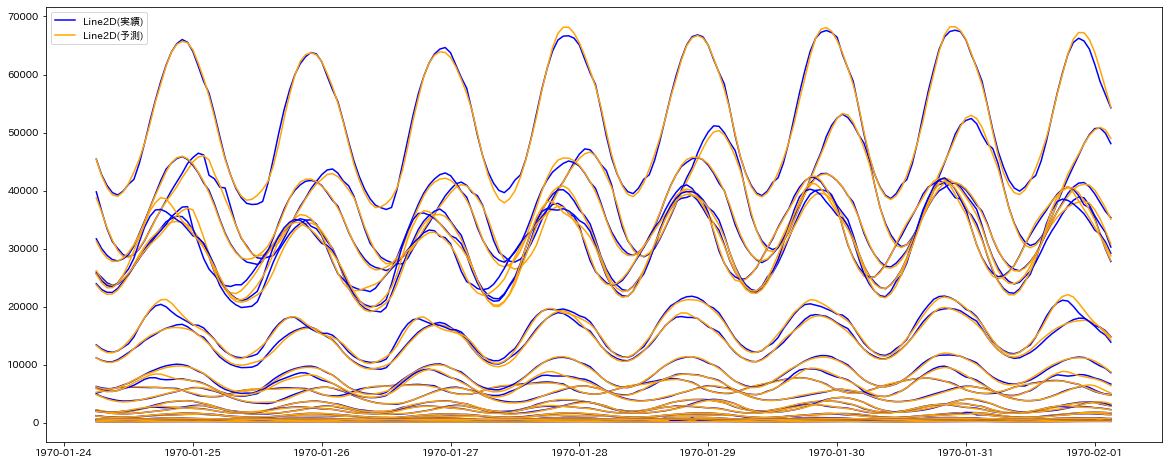

In [ ]:
t.figure(figsize=(20, 8))
handles = [] 

for i in range(len(result_df["series"].unique())):

    each_series_df = result_df[result_df["series"]==result_df["series"].unique()[i]]

    line1, = t.ot(
        each_series_df["ds"],
        each_series_df["value"],
        label="実績",
        color="blue"
        )
    
    line2, = t.ot(
        each_series_df["ds"],
        each_series_df["pred"],
        label="予測",
        color="orange"
    )

    if i % 22 == 0: # 同色をまとめる
        handles.append(line1)
        handles.append(line2)

t.legend(handles)